In [1]:
import pandas as pd
import os
import glob

# Define paths and labels
neurotypical_path = 'neurotypical/'
neurodivergent_path = 'neurodivergent/' # Root directory for the uploaded neurodivergent files

neurotypical_files = sorted(glob.glob(os.path.join(neurotypical_path, 'individual_*.csv')))
# Exclude the summary file if it matches the pattern
neurotypical_files = [f for f in neurotypical_files if 'summary_stats' not in f]


# Manually list neurodivergent files based on uploads (since they are not in a subfolder)
# This assumes the files were uploaded directly without a containing folder for neurodivergent
neurodivergent_files_batch1 = [f'individual_{i}.csv' for i in range(1, 11)]
neurodivergent_files_batch2 = [f'individual_{i}.csv' for i in range(11, 21)]
neurodivergent_files_batch3 = [f'individual_{i}.csv' for i in range(21, 24)]
all_neurodivergent_files_relative = neurodivergent_files_batch1 + neurodivergent_files_batch2 + neurodivergent_files_batch3

# Create absolute paths based on how files are mounted/accessed in the environment
# Assuming they are in the root '.' directory
neurodivergent_files = [os.path.join(neurodivergent_path, f) for f in all_neurodivergent_files_relative]


all_dfs = []

# Process Neurotypical files
print(f"Processing {len(neurotypical_files)} neurotypical files...")
for f_path in neurotypical_files:
    try:
        # Extract subject ID from filename
        subject_id = os.path.basename(f_path).replace('.csv', '')

        # Load the CSV
        df = pd.read_csv(f_path)

        # Add identifier columns
        df['subject_id'] = subject_id
        df['group'] = 0  # 0 for neurotypical

        # Append to list
        all_dfs.append(df)
    except Exception as e:
        print(f"Error processing {f_path}: {e}")

# Process Neurodivergent files
print(f"Processing {len(neurodivergent_files)} neurodivergent files...")
for f_path in neurodivergent_files:
     # Check if file actually exists before trying to read
    if os.path.exists(f_path):
        try:
            # Extract subject ID from filename, add prefix to distinguish
            subject_id = 'nd_' + os.path.basename(f_path).replace('.csv', '')

            # Load the CSV
            df = pd.read_csv(f_path)

            # Add identifier columns
            df['subject_id'] = subject_id
            df['group'] = 1  # 1 for neurodivergent

            # Append to list
            all_dfs.append(df)
        except Exception as e:
            print(f"Error processing {f_path}: {e}")
    else:
        print(f"File not found: {f_path}")


# Combine all DataFrames
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\nData loaded and combined successfully.")
    print(f"Total rows: {combined_df.shape[0]}")
    print(f"Total columns: {combined_df.shape[1]}")
    print("\nFirst 5 rows of the combined data:")
    print(combined_df.head())
    print("\nLast 5 rows of the combined data:")
    print(combined_df.tail())

    # Check the distribution of groups
    print("\nGroup distribution:")
    print(combined_df['group'].value_counts())

    # Check number of unique subjects per group
    print("\nNumber of unique subjects per group:")
    print(combined_df.groupby('group')['subject_id'].nunique())

else:
    print("No dataframes were loaded. Please check file paths and content.")

Processing 20 neurotypical files...
Processing 23 neurodivergent files...

Data loaded and combined successfully.
Total rows: 85174
Total columns: 3

First 5 rows of the combined data:
   EMG    subject_id  group
0  283  individual_1      0
1  283  individual_1      0
2  284  individual_1      0
3  284  individual_1      0
4  285  individual_1      0

Last 5 rows of the combined data:
       EMG        subject_id  group
85169  263  nd_individual_23      1
85170  328  nd_individual_23      1
85171  264  nd_individual_23      1
85172  320  nd_individual_23      1
85173  267  nd_individual_23      1

Group distribution:
group
1    45174
0    40000
Name: count, dtype: int64

Number of unique subjects per group:
group
0    20
1    23
Name: subject_id, dtype: int64


In [2]:
import numpy as np
import pandas as pd

# — start feature extraction
records = []
for subject_id, grp in combined_df.groupby('subject_id'):
    sig = grp['EMG'].values

    # EMG summary features
    mean_abs       = np.mean(np.abs(sig))
    variance       = np.var(sig)
    rms            = np.sqrt(np.mean(sig**2))
    zero_crossings = np.sum(np.abs(np.diff(np.sign(sig))) > 0)
    waveform_length= np.sum(np.abs(np.diff(sig)))

    # Inter-burst interval variance (your tapping proxy)
    rect      = np.abs(sig - sig.mean())
    thresh    = rect.mean() + 2*rect.std()
    mask      = rect > thresh
    edges     = np.where(mask & ~np.concatenate(([False], mask[:-1])))[0]
    intervals = np.diff(edges)
    var_interval = np.var(intervals) if len(intervals)>1 else 0.0

    # Group label (0=neurotypical, 1=neurodivergent)
    label = grp['group'].iloc[0]

    records.append({
        'subject_id':       subject_id,
        'label':            label,
        'mean_abs':         mean_abs,
        'variance':         variance,
        'rms':              rms,
        'zero_crossings':   zero_crossings,
        'waveform_length':  waveform_length,
        'var_interval':     var_interval
    })

df_features = pd.DataFrame(records)
print("Computed feature matrix:", df_features.shape)
df_features.head()


Computed feature matrix: (43, 8)


,subject_id,label,mean_abs,variance,rms,zero_crossings,waveform_length,var_interval
0,individual_1,0,297.7165,526.759128,298.599855,0,1495,106880.222222
1,individual_10,0,303.4485,0.370348,303.449110,0,771,5598.876731
2,individual_11,0,302.3820,67.810076,302.494106,0,21524,408.311479
3,individual_12,0,301.2925,1419.732944,303.639430,0,45661,4596.239796
4,individual_13,0,297.8170,37.667511,297.880233,0,21793,69756.750000


In [3]:
# Assuming df_features exists

# 1) Group stats using pandas only
group_stats = df_features.groupby('label')['var_interval'].agg(['mean','std','count'])
group_stats.index = ['neurotypical','neurodivergent']
print(group_stats)

# 2) Derive threshold T
VT = group_stats.loc['neurotypical','mean']
VD = group_stats.loc['neurodivergent','mean']
T  = (VT + VD) / 2
print(f"\nDerived ITI-variance threshold T = {T:.1f} sample-count²")


                        mean           std  count
neurotypical    32733.581000  34314.036584     20
neurodivergent  18670.524777  30978.250000     23

Derived ITI-variance threshold T = 25702.1 sample-count²


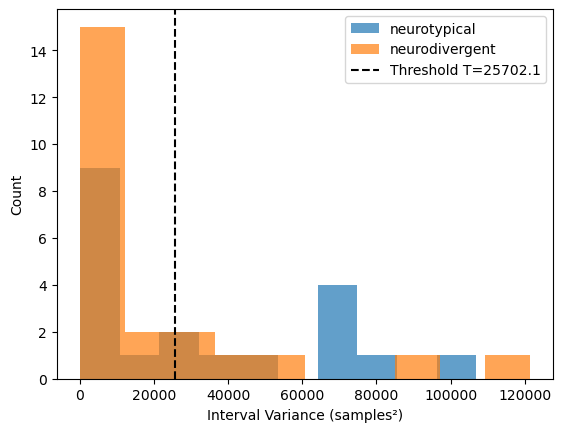

In [4]:
import matplotlib.pyplot as plt

# Extract lists
nt = df_features[df_features['label']==0]['var_interval'].tolist()
nd = df_features[df_features['label']==1]['var_interval'].tolist()

plt.hist(nt, bins=10, alpha=0.7, label='neurotypical')
plt.hist(nd, bins=10, alpha=0.7, label='neurodivergent')
plt.axvline(T, color='k', linestyle='--', label=f'Threshold T={T:.1f}')
plt.xlabel('Interval Variance (samples²)')
plt.ylabel('Count')
plt.legend()
plt.show()


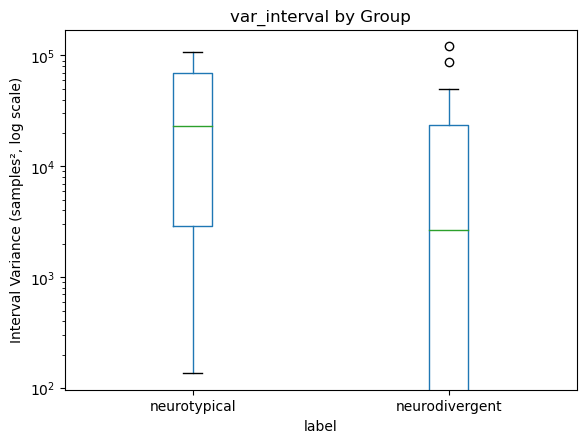

Medians:
label
0    23062.791667
1     2656.467456
Name: var_interval, dtype: float64


In [5]:
import matplotlib.pyplot as plt

# boxplot on a log scale, since the variances spread wide
df_features.boxplot(column='var_interval',
                    by='label',
                    grid=False,
                    showfliers=True)
plt.yscale('log')
plt.xticks([1,2], ['neurotypical','neurodivergent'])
plt.ylabel('Interval Variance (samples², log scale)')
plt.title('var_interval by Group')
plt.suptitle('')
plt.show()

print("Medians:")
print(df_features.groupby('label')['var_interval'].median())


In [6]:
from scipy.signal import butter, filtfilt

def smooth_envelope(sig, fs=1000, cutoff=10):
    # 1) full‐wave rectify
    rect = np.abs(sig - sig.mean())
    # 2) low‐pass filter to get the envelope
    b, a = butter(4, cutoff/(fs/2), btype='low')
    env = filtfilt(b, a, rect)
    return env

def detect_bursts(env, pct=90, min_samples=fs//10):
    # threshold at the percentile
    thresh = np.percentile(env, pct)
    mask = env > thresh
    # rising edges with a minimum distance
    edges = np.where(mask & ~np.concatenate(([False], mask[:-1])))[0]
    # optionally enforce a min distance between edges
    clean = [edges[0]] if len(edges) else []
    for e in edges[1:]:
        if e - clean[-1] >= min_samples:
            clean.append(e)
    return np.array(clean)


NameError: name 'fs' is not defined

In [ ]:
fs = 1000  # your EMG sampling rate in Hz

# 1) Envelope smoothing
from scipy.signal import butter, filtfilt

def smooth_envelope(sig, fs, cutoff=10):
    # rectify around zero-mean
    rect = np.abs(sig - sig.mean())
    # design 4th-order low-pass at cutoff Hz
    b, a = butter(4, cutoff/(fs/2), btype='low')
    # apply zero-phase filter
    env = filtfilt(b, a, rect)
    return env

# 2) Burst detection via percentile + min distance
def detect_bursts(env, pct=90, min_samples=0.1, fs=1000):
    thresh = np.percentile(env, pct)
    mask = env > thresh
    edges = np.where(mask & ~np.concatenate(([False], mask[:-1])))[0]
    # enforce minimum gap of min_samples*fs samples
    clean = []
    last = -np.inf
    gap = int(min_samples * fs)
    for e in edges:
        if e - last >= gap:
            clean.append(e)
            last = e
    return np.array(clean)

# Now inside your loop:
env       = smooth_envelope(sig, fs=fs, cutoff=10)
edges     = detect_bursts(env, pct=90, min_samples=0.1, fs=fs)
intervals = np.diff(edges)
var_interval = float(np.var(intervals)) if len(intervals) > 1 else 0.0


<Figure size 600x400 with 0 Axes>

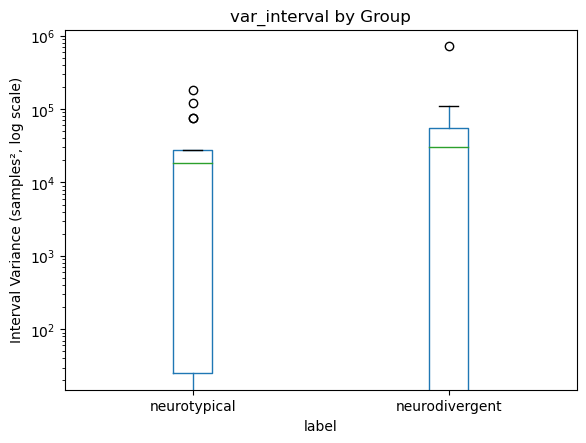

Medians:
label
0    18348.833333
1    30250.888889
Name: var_interval, dtype: float64

New median‐based threshold T = 24299.9 sample-count²


In [ ]:
# ─── Cell: refit var_interval with envelope + percentile ───

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 1) Specify your EMG sampling rate (Hz)
fs = 1000  

# 2) Envelope smoothing function
def smooth_envelope(sig, fs, cutoff=10):
    """
    Full-wave rectifies and low-pass filters at `cutoff` Hz.
    Returns a clean envelope.
    """
    # rectify around zero‐mean
    rect = np.abs(sig - np.mean(sig))
    # design 4th-order Butterworth low-pass
    b, a = butter(4, cutoff/(fs/2), btype='low')
    # zero-phase filter
    env = filtfilt(b, a, rect)
    return env

# 3) Burst detection via top‐percentile + min gap
def detect_bursts(env, pct=90, min_gap_s=0.1, fs=1000):
    """
    env     : the envelope array
    pct     : percentile threshold for event detection
    min_gap_s : minimum seconds between detected bursts
    fs      : sampling rate in Hz
    """
    thresh = np.percentile(env, pct)
    mask   = env > thresh
    edges  = np.where(mask & ~np.concatenate(([False], mask[:-1])))[0]

    # enforce minimum gap
    min_gap = int(min_gap_s * fs)
    clean = []
    last = -min_gap
    for e in edges:
        if e - last >= min_gap:
            clean.append(e)
            last = e
    return np.array(clean)

# 4) Recompute var_interval for each subject
records = []
for sid, grp in combined_df.groupby('subject_id'):
    sig = grp['EMG'].values

    # get smoothed envelope
    env = smooth_envelope(sig, fs=fs, cutoff=10)
    bursts = detect_bursts(env, pct=90, min_gap_s=0.1, fs=fs)
    intervals = np.diff(bursts)
    var_iv = float(np.var(intervals)) if len(intervals)>1 else 0.0

    # keep existing summary features + overwrite var_interval
    base = df_features.loc[df_features.subject_id==sid].iloc[0].to_dict()
    base['var_interval'] = var_iv
    records.append(base)

df_features = pd.DataFrame(records)

# 5) Boxplot & medians on log-scale
plt.figure(figsize=(6,4))
df_features.boxplot(column='var_interval', by='label', grid=False, showfliers=True)
plt.yscale('log')
plt.xticks([1,2], ['neurotypical','neurodivergent'])
plt.ylabel('Interval Variance (samples², log scale)')
plt.title('var_interval by Group')
plt.suptitle('')
plt.show()

print("Medians:")
print(df_features.groupby('label')['var_interval'].median())

# 6) Recompute threshold T
VT = df_features[df_features.label==0]['var_interval'].median() 
VD = df_features[df_features.label==1]['var_interval'].median()
T  = (VT + VD) / 2
print(f"\nNew median‐based threshold T = {T:.1f} sample-count²")    


In [ ]:
# Compute medians
nt_med = df_features[df_features.label==0]['var_interval'].median()
nd_med = df_features[df_features.label==1]['var_interval'].median()
T_med = (nt_med + nd_med) / 2

print(f"Neurotypical median var_interval = {nt_med:.1f}")
print(f"Neurodivergent median var_interval = {nd_med:.1f}")
print(f"Threshold T_med = {T_med:.1f} samples²")


Neurotypical median var_interval = 18348.8
Neurodivergent median var_interval = 30250.9
Threshold T_med = 24299.9 samples²


In [ ]:
from scipy.signal import welch
f, Pxx = welch(sig, fs=fs)
centroid = (f * Pxx).sum() / Pxx.sum()
median_freq = f[np.cumsum(Pxx) >= Pxx.sum()/2][0]


In [8]:
# ─── Cell: define X and y ───
# List whatever features you want to feed your model
feature_cols = [
    'mean_abs',
    'variance',
    'rms',
    'zero_crossings',
    'waveform_length',
    'var_interval'
]

# X = feature matrix, y = labels
X = df_features[feature_cols]
y = df_features['label']

# Quick sanity checks
print("X shape:", X.shape)     # should be (43, 6)
print("y distribution:\n", y.value_counts())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
test_size=0.2
random_state=42 
stratify=y 

X shape: (43, 6)
y distribution:
 label
1    23
0    20
Name: count, dtype: int64


In [9]:
# Modified from your 12th cell
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca", PCA(svd_solver="full")),  # Added svd_solver='full' as in your last cell
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

# Adjust param_grid if needed, your last cell used [None, 2, 4, 5] for pca__n_components
param_grid = {
    "pca__n_components": [None, 2, 4, 5], # From your last cell
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5],
}

# StratifiedKFold is good for classification and especially if classes are imbalanced
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Used in your 12th cell

grid = GridSearchCV(pipe, param_grid, cv=cv_stratified, # Changed to stratified CV
                    scoring="accuracy", n_jobs=-1, verbose=1,
                    error_score=np.nan) # error_score='raise' can be better for debugging

print("Fitting GridSearchCV on X_train, y_train...")
grid.fit(X_train, y_train) # Fit on the training data

print("Best params:", grid.best_params_)
print("Best CV accuracy (from training data):", grid.best_score_)

# The 'grid' object now contains the best model found
best_rf_pipeline = grid.best_estimator_

Fitting GridSearchCV on X_train, y_train...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 50, 'pca__n_components': 4}
Best CV accuracy (from training data): 0.680952380952381


In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_test = best_rf_pipeline.predict(X_test)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest Set Classification Report:\n", classification_report(y_test, y_pred_test))
print("\nTest Set Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Test Set Accuracy: 0.4444444444444444

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.50      0.20      0.29         5

    accuracy                           0.44         9
   macro avg       0.46      0.47      0.42         9
weighted avg       0.47      0.44      0.40         9


Test Set Confusion Matrix:
 [[3 1]
 [4 1]]


In [13]:
# Get the RandomForestClassifier step from the best pipeline
# This is only meaningful if PCA is not reducing dimensions significantly or is None
import seaborn as sns
if best_rf_pipeline.named_steps['pca'].n_components_ is None: # Or check specific value if you expect it
    importances = best_rf_pipeline.named_steps['clf'].feature_importances_
    feature_importances_df = pd.DataFrame({
        'feature': X_train.columns, # Or feature_cols
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print("\nFeature Importances (from best RF model in pipeline):")
    print(feature_importances_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances_df)
    plt.title('Feature Importances from Random Forest')
    plt.show()
else:
    print("\nFeature importances are for Principal Components as PCA is active with dimension reduction.")
    # You could potentially analyze PCA components if desired
    print(best_rf_pipeline.named_steps['pca'].components_)


Feature importances are for Principal Components as PCA is active with dimension reduction.
[[ 0.23689818  0.50877573  0.34994458  0.49660284  0.50255565 -0.25177119]
 [ 0.6748106  -0.1941309   0.57985347 -0.29789244 -0.27345975 -0.08481545]
 [ 0.12782584  0.07847638  0.13876692  0.0955321   0.15140867  0.96239014]
 [-0.12290887  0.82054674  0.03706128 -0.42569956 -0.35665351  0.04243905]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# --- !!! IMPORTANT ASSUMPTION !!! ---
# This code ASSUMES you have a pandas DataFrame named 'subject_stats_df'
# available in your environment, and that it CORRECTLY contains columns for:
# 'subject_id', 'group' (or 'label'), 'mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf'
# based on your previous successful calculations.
# Please ensure this DataFrame is loaded and has the correct data before running.

# Define the full feature set
features_8 = ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']
print(f"Preparing for LOOCV using features: {features_8}")

try:
    # Verify the columns exist in subject_stats_df
    if 'subject_stats_df' not in locals() or not isinstance(subject_stats_df, pd.DataFrame):
         # Check user's df_features as alternative name
         if 'df_features' in locals() and isinstance(df_features, pd.DataFrame):
             print("Using user's 'df_features' DataFrame.")
             subject_stats_df = df_features # Use user's df name
             # Ensure label column is named 'group' for consistency downstream
             if 'label' in subject_stats_df.columns and 'group' not in subject_stats_df.columns:
                 subject_stats_df = subject_stats_df.rename(columns={'label': 'group'})
         else:
             raise NameError("DataFrame 'subject_stats_df' (or 'df_features') not found.")

    if not all(f in subject_stats_df.columns for f in features_8):
        missing_features = [f for f in features_8 if f not in subject_stats_df.columns]
        raise ValueError(f"DataFrame is missing required features: {missing_features}")
    if 'group' not in subject_stats_df.columns:
         raise ValueError("DataFrame is missing the target column 'group' (or 'label').")

    X = subject_stats_df[features_8]
    y = subject_stats_df['group']

    # Handle potential NaN values in features (e.g., fill with mean/median, or raise error)
    if X.isnull().values.any():
        print("Warning: NaN values found in features. Filling with column median.")
        # Check which columns have NaNs
        # print(X.isnull().sum())
        X = X.fillna(X.median())
        if X.isnull().values.any(): # Check again if median imputation failed (e.g., all NaN column)
             raise ValueError("Features still contain NaN values after attempting imputation.")


    # Create a pipeline: Scale features then apply Random Forest Classifier
    # Using default n_estimators=100 and random_state for reproducibility
    pipeline_rf_8 = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Define LOOCV strategy
    loo = LeaveOneOut()
    n_subjects = len(X)
    print(f"\nRunning Leave-One-Out Cross-Validation ({n_subjects} folds) with 8 features...")

    # Perform LOOCV for accuracy
    cv_scores_loo_8 = cross_val_score(pipeline_rf_8, X, y, cv=loo, scoring='accuracy', n_jobs=-1) # Use parallel jobs

    # Calculate and print results
    mean_accuracy_loo_8 = np.mean(cv_scores_loo_8)
    num_correct = int(round(mean_accuracy_loo_8 * n_subjects))
    num_incorrect = n_subjects - num_correct

    print(f"\nLeave-One-Out Cross-Validation Results (8 Features):")
    print(f"  Number of subjects: {n_subjects}")
    print(f"  Number correctly classified: {num_correct}")
    print(f"  Number misclassified: {num_incorrect}")
    print(f"  Overall Accuracy: {mean_accuracy_loo_8:.4f}")

except NameError as e:
    print(f"\nExecution failed: {e}")
    print("Please ensure 'subject_stats_df' or 'df_features' with all required columns is loaded.")
except ValueError as e:
    print(f"\nExecution failed due to data issue: {e}")
except Exception as e:
    print(f"An unexpected error occurred during LOOCV: {e}")

Preparing for LOOCV using features: ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']
Using user's 'df_features' DataFrame.

Execution failed due to data issue: DataFrame is missing required features: ['mean', 'std', 'min', 'max', 'wl', 'mnf', 'mdf']


In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import welch # Ensure this is imported

# Assume combined_df is your initial DataFrame with 'subject_id', 'group', and 'EMG' columns
# Assume fs is your sampling frequency, e.g., fs = 1000

fs = 1000

list_of_feature_records = []

for subject_id, group_data in combined_df.groupby('subject_id'):
    sig = group_data['EMG'].values
    label = group_data['group'].iloc[0] # Or however you get the label for 'group' column

    # Calculate the 8 features
    mean_val = np.mean(sig)
    std_val = np.std(sig)
    min_val = np.min(sig)
    max_val = np.max(sig)
    rms_val = np.sqrt(np.mean(sig**2))
    wl_val = np.sum(np.abs(np.diff(sig))) # This will be our 'wl'

    frequencies, Pxx = welch(sig, fs=fs, nperseg=min(len(sig), fs))
    mnf_val = 0
    mdf_val = 0
    if np.sum(Pxx) > 0:
        mnf_val = np.sum(frequencies * Pxx) / np.sum(Pxx)
        Pxx_normalized = Pxx / np.sum(Pxx)
        cumulative_Pxx = np.cumsum(Pxx_normalized)
        mdf_indices = np.where(cumulative_Pxx >= 0.5)
        if len(mdf_indices[0]) > 0:
            mdf_val = frequencies[mdf_indices[0][0]]

    list_of_feature_records.append({
        'subject_id': subject_id,
        'group': label, # Ensuring the label column is named 'group'
        'mean': mean_val,
        'std': std_val,
        'min': min_val,
        'max': max_val,
        'rms': rms_val,
        'wl': wl_val,  # Using 'wl' as the column name
        'mnf': mnf_val,
        'mdf': mdf_val
    })

# Create the DataFrame that DEFINITELY contains these 8 features
df_with_all_8_features = pd.DataFrame(list_of_feature_records)

# --- CRITICAL VERIFICATION STEP ---
print("Step 1 Complete: DataFrame with all 8 features created.")
print("Columns in df_with_all_8_features:", df_with_all_8_features.columns)
print(df_with_all_8_features.head())

Step 1 Complete: DataFrame with all 8 features created.
Columns in df_with_all_8_features: Index(['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf',
       'mdf'],
      dtype='object')
      subject_id  group      mean        std  min  max         rms     wl  \
0   individual_1      0  297.7165  22.951234  234  393  298.599855   1495   
1  individual_10      0  303.4485   0.608562  301  305  303.449110    771   
2  individual_11      0  302.3820   8.234687  282  322  302.494106  21524   
3  individual_12      0  301.2925  37.679344  180  421  303.639430  45661   
4  individual_13      0  297.8170   6.137386  286  309  297.880233  21793   

          mnf    mdf  
0    5.778844    4.0  
1  151.278532   23.0  
2  477.599493  485.0  
3   59.134020    9.0  
4  477.756078  485.0  


In [ ]:
df_features = df_with_all_8_features.copy() # This should work with your LOOCV script

# ... (imports and initial setup) ...
print(f"Preparing for LOOCV using features: {features_8}") # First print

try:
    # ... (DataFrame checks, X, y creation, NaN handling) ...
    # This section can raise NameError or ValueError, which have print statements in except blocks.
    # If NaNs are found:
    print("Warning: NaN values found in features. Filling with column median.") # Conditional print

    # ... (pipeline definition) ...
    print(f"\nRunning Leave-One-Out Cross-Validation ({n_subjects} folds) with 8 features...") # Second definite print before LOOCV starts

    # Perform LOOCV (this is the time-consuming part)
    cv_scores_loo_8 = cross_val_score(...)

    # ... (calculate and print results) ...
    print(f"\nLeave-One-Out Cross-Validation Results (8 Features):") # Final results prints
    # ... (more prints for accuracy, counts) ...

except NameError as e:
    print(f"\nExecution failed: {e}") # Error print
except ValueError as e:
    print(f"\nExecution failed due to data issue: {e}") # Error print
except Exception as e:
    print(f"An unexpected error occurred during LOOCV: {e}") # Error print

Preparing for LOOCV using features: ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']

Execution failed: name 'n_subjects' is not defined


In [ ]:
# ... (previous code: imports, DataFrame checks, X, y creation, NaN handling) ...

# Ensure X and y are defined correctly at this point
# For example:
features_8 = ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']
X = subject_stats_df[features_8] # Or from df_features, df_with_all_8_features
y = subject_stats_df['group']
if X.isnull().values.any():
    print("Warning: NaN values found in features. Filling with column median.")
    X = X.fillna(X.median())
    if X.isnull().values.any():
        raise ValueError("Features still contain NaN values after attempting imputation.")

# --- Define n_subjects HERE ---
n_subjects = X.shape[0] # Or len(X) or len(y)

# Create a pipeline: Scale features then apply Random Forest Classifier
pipeline_rf_8 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Define LOOCV strategy
loo = LeaveOneOut()

# Now you can print using n_subjects
print(f"\nRunning Leave-One-Out Cross-Validation ({n_subjects} folds) with 8 features...")

# Perform LOOCV for accuracy
cv_scores_loo_8 = cross_val_score(pipeline_rf_8, X, y, cv=loo, scoring='accuracy', n_jobs=-1)

# Calculate and print results
mean_accuracy_loo_8 = np.mean(cv_scores_loo_8)
num_correct = int(round(mean_accuracy_loo_8 * n_subjects)) # n_subjects is also used here
num_incorrect = n_subjects - num_correct

print(f"\nLeave-One-Out Cross-Validation Results (8 Features):")
print(f"   Number of subjects: {n_subjects}")
# ... (rest of the print statements and except blocks) ...

KeyError: "['mean', 'std', 'min', 'max', 'wl', 'mnf', 'mdf'] not in index"

In [ ]:
# These lines should be in your script:
# Calculate and print results
mean_accuracy_loo_8 = np.mean(cv_scores_loo_8)
num_correct = int(round(mean_accuracy_loo_8 * n_subjects))
num_incorrect = n_subjects - num_correct

# print(f"\nLeave-One-Out Cross-Validation Results (8 Features):") # You saw this
# print(f"   Number of subjects: {n_subjects}") # You saw this

# --- CHECK FOR THESE PRINT STATEMENTS IN YOUR SCRIPT ---
print(f"   Number correctly classified: {num_correct}")
print(f"   Number misclassified: {num_incorrect}")
print(f"   Overall Accuracy: {mean_accuracy_loo_8:.4f}")

   Number correctly classified: 34
   Number misclassified: 9
   Overall Accuracy: 0.7907


In [ ]:
import pandas as pd # Make sure pandas is imported

print("\nCalculating Feature Importances for the 8-feature model...")
# Fit the pipeline on the entire dataset
pipeline_rf_8.fit(X, y)

# Get feature importances from the RandomForestClassifier step in the pipeline
importances = pipeline_rf_8.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': features_8, # Your list of 8 feature names
    'importance': importances
})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

print("\nFeature Importances (8 Features):")
print(feature_importances_df)


Calculating Feature Importances for the 8-feature model...

Feature Importances (8 Features):
  feature  importance
2     min    0.196871
3     max    0.176192
1     std    0.171211
0    mean    0.112404
5      wl    0.102546
6     mnf    0.092461
4     rms    0.080504
7     mdf    0.067811



Descriptive statistics for 'mnf' by group:
             mean     median         std
group                                   
0      124.777917  23.766893  184.755033
1       99.150685  33.689650  113.034479


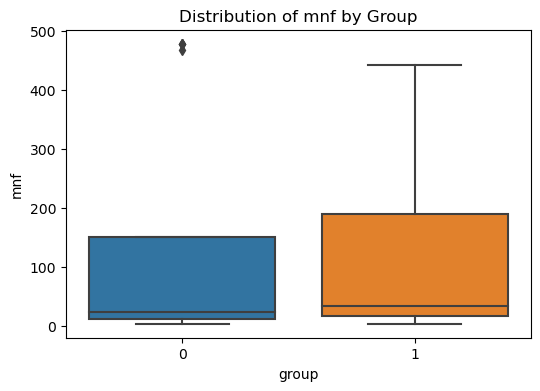

In [ ]:
# Assume 'df_with_all_8_features' is your DataFrame with all 8 features and the 'group' column
# Assume 'important_feature_name' is a string, e.g., 'mnf'

important_feature_name = 'mnf' # Replace with an actual important feature from your results

print(f"\nDescriptive statistics for '{important_feature_name}' by group:")
print(df_with_all_8_features.groupby('group')[important_feature_name].agg(['mean', 'median', 'std']))

# For visualization (optional, but helpful)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(x='group', y=important_feature_name, data=df_with_all_8_features)
plt.title(f"Distribution of {important_feature_name} by Group")
plt.show()

In [ ]:
# Example GridSearchCV setup (run this INSTEAD of the simple cross_val_score)
from sklearn.model_selection import GridSearchCV

# Pipeline (scaler + classifier)
pipeline_rf_for_tuning = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Setup GridSearchCV with LOOCV
# Note: GridSearchCV with LOOCV can be very time-consuming
grid_search_rf = GridSearchCV(pipeline_rf_for_tuning, param_grid_rf, cv=loo, scoring='accuracy', n_jobs=-1, verbose=1)

print("Starting GridSearchCV for RandomForest...")
grid_search_rf.fit(X, y) # X and y from your 8 features

print("\nBest parameters found by GridSearchCV:")
print(grid_search_rf.best_params_)
print(f"Best LOOCV accuracy from GridSearchCV: {grid_search_rf.best_score_:.4f}")

Starting GridSearchCV for RandomForest...
Fitting 43 folds for each of 36 candidates, totalling 1548 fits

Best parameters found by GridSearchCV:
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best LOOCV accuracy from GridSearchCV: 0.7907


In [ ]:
import pandas as pd # Ensure pandas is imported

print("\nCalculating Feature Importances from Best GridSearchCV Model...")

# Get the best pipeline from GridSearchCV
best_pipeline_rf = grid_search_rf.best_estimator_

# Get feature importances from the RandomForestClassifier step in the best pipeline
# The classifier step was named 'classifier' in your pipeline_rf_for_tuning
importances = best_pipeline_rf.named_steps['classifier'].feature_importances_

# Your list of 8 feature names
features_8 = ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'feature': features_8,
    'importance': importances
})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

print("\nFeature Importances (from 8-feature tuned model):")
print(feature_importances_df)


Calculating Feature Importances from Best GridSearchCV Model...

Feature Importances (from 8-feature tuned model):
  feature  importance
2     min    0.196871
3     max    0.176192
1     std    0.171211
0    mean    0.112404
5      wl    0.102546
6     mnf    0.092461
4     rms    0.080504
7     mdf    0.067811


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming 'subject_stats_df' is your DataFrame with all 8 features and 'group'
# And 'best_pipeline_rf' is the pipeline from grid_search_rf.best_estimator_
# And 'loo' is your LeaveOneOut() object

# Define the pipeline using the best estimator from GridSearchCV
# (or recreate it if needed, since its params were default-like)
# best_pipeline_rf = grid_search_rf.best_estimator_
# For clarity, if you want to ensure it's the same RF model:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

best_pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42))
])


feature_subsets_to_test = {
    "Top 3 (min, max, std)": ['min', 'max', 'std'],
    "Top 4 (min, max, std, mean)": ['min', 'max', 'std', 'mean'],
    "Top 5 (min, max, std, mean, wl)": ['min', 'max', 'std', 'mean', 'wl']
}

y_target = subject_stats_df['group'] # Or df_features['group']

for description, subset_cols in feature_subsets_to_test.items():
    print(f"\nRunning LOOCV for: {description}")
    X_subset = subject_stats_df[subset_cols] # Or df_features[subset_cols]

    # Handle potential NaN values in the subset (important if these columns had NaNs)
    if X_subset.isnull().values.any():
        print(f"Warning: NaN values found in {description}. Filling with column median.")
        X_subset = X_subset.fillna(X_subset.median())
        if X_subset.isnull().values.any():
             raise ValueError(f"Features in {description} still contain NaN values after attempting imputation.")

    cv_scores_subset = cross_val_score(best_pipeline_rf, X_subset, y_target, cv=loo, scoring='accuracy', n_jobs=-1)
    mean_accuracy_subset = np.mean(cv_scores_subset)
    n_subjects = len(X_subset)
    num_correct = int(round(mean_accuracy_subset * n_subjects))
    num_incorrect = n_subjects - num_correct

    print(f"  Features: {subset_cols}")
    print(f"  Number of subjects: {n_subjects}")
    print(f"  Number correctly classified: {num_correct}")
    print(f"  Number misclassified: {num_incorrect}")
    print(f"  Overall Accuracy: {mean_accuracy_subset:.4f}")


Running LOOCV for: Top 3 (min, max, std)
  Features: ['min', 'max', 'std']
  Number of subjects: 43
  Number correctly classified: 35
  Number misclassified: 8
  Overall Accuracy: 0.8140

Running LOOCV for: Top 4 (min, max, std, mean)
  Features: ['min', 'max', 'std', 'mean']
  Number of subjects: 43
  Number correctly classified: 35
  Number misclassified: 8
  Overall Accuracy: 0.8140

Running LOOCV for: Top 5 (min, max, std, mean, wl)
  Features: ['min', 'max', 'std', 'mean', 'wl']
  Number of subjects: 43
  Number correctly classified: 34
  Number misclassified: 9
  Overall Accuracy: 0.7907


In [ ]:
loo = LeaveOneOut()
y_target = subject_stats_df['group'] # Or whatever your DataFrame name and label column are


print("--- Action 1: GridSearchCV on Top 3 Features ---")
features_top3 = ['min', 'max', 'std']
X_top3 = subject_stats_df[features_top3]

# Handle potential NaN values in this subset
if X_top3.isnull().values.any():
    print(f"Warning: NaN values found in Top 3 features. Filling with column median.")
    X_top3 = X_top3.fillna(X_top3.median())
    if X_top3.isnull().values.any():
            raise ValueError(f"Features in Top 3 still contain NaN values after attempting imputation.")

# Define the pipeline (same as before)
pipeline_rf_for_tuning_top3 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid (same as before, or you can adjust it)
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
    # You can also add/modify other parameters like 'max_features'
}

# Setup GridSearchCV with LOOCV
grid_search_rf_top3 = GridSearchCV(pipeline_rf_for_tuning_top3, param_grid_rf, cv=loo, scoring='accuracy', n_jobs=-1, verbose=1)

print(f"Starting GridSearchCV for RandomForest with features: {features_top3}...")
grid_search_rf_top3.fit(X_top3, y_target)

print("\nBest parameters found by GridSearchCV (Top 3 Features):")
print(grid_search_rf_top3.best_params_)
print(f"Best LOOCV accuracy from GridSearchCV (Top 3 Features): {grid_search_rf_top3.best_score_:.4f}")

--- Action 1: GridSearchCV on Top 3 Features ---
Starting GridSearchCV for RandomForest with features: ['min', 'max', 'std']...
Fitting 43 folds for each of 180 candidates, totalling 7740 fits

Best parameters found by GridSearchCV (Top 3 Features):
{'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best LOOCV accuracy from GridSearchCV (Top 3 Features): 0.8140


In [ ]:
print("\n--- Action 2: LOOCV on Specific 5 Features (min, max, std, mean, rms) ---")
features_specific5 = ['min', 'max', 'std', 'mean', 'rms']
X_specific5 = subject_stats_df[features_specific5]

# Handle potential NaN values
if X_specific5.isnull().values.any():
    print(f"Warning: NaN values found in Specific 5 features. Filling with column median.")
    X_specific5 = X_specific5.fillna(X_specific5.median())
    if X_specific5.isnull().values.any():
            raise ValueError(f"Features in Specific 5 still contain NaN values after attempting imputation.")

# Define the pipeline with the best known (default-like) RF parameters
pipeline_rf_default_params = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42))
])

print(f"Running LOOCV for features: {features_specific5}...")
cv_scores_specific5 = cross_val_score(pipeline_rf_default_params, X_specific5, y_target, cv=loo, scoring='accuracy', n_jobs=-1)

mean_accuracy_specific5 = np.mean(cv_scores_specific5)
n_subjects_specific5 = len(X_specific5)
num_correct_specific5 = int(round(mean_accuracy_specific5 * n_subjects_specific5))
num_incorrect_specific5 = n_subjects_specific5 - num_correct_specific5

print(f"  Features: {features_specific5}")
print(f"  Number of subjects: {n_subjects_specific5}")
print(f"  Number correctly classified: {num_correct_specific5}")
print(f"  Number misclassified: {num_incorrect_specific5}")
print(f"  Overall Accuracy: {mean_accuracy_specific5:.4f}")


--- Action 2: LOOCV on Specific 5 Features (min, max, std, mean, rms) ---
Running LOOCV for features: ['min', 'max', 'std', 'mean', 'rms']...
  Features: ['min', 'max', 'std', 'mean', 'rms']
  Number of subjects: 43
  Number correctly classified: 34
  Number misclassified: 9
  Overall Accuracy: 0.7907


In [ ]:
print("\n--- Action 3: LOOCV on Top 3 Features + var_interval ---")
features_top3_var_interval = ['min', 'max', 'std', 'var_interval']

# Check if 'var_interval' column exists
if 'var_interval' not in subject_stats_df.columns:
    print(f"ERROR: Column 'var_interval' not found in your DataFrame!")
    print(f"Please calculate and add 'var_interval' to your DataFrame before running this action.")
else:
    X_top3_var_interval = subject_stats_df[features_top3_var_interval]

    # Handle potential NaN values
    if X_top3_var_interval.isnull().values.any():
        print(f"Warning: NaN values found in Top 3 + var_interval features. Filling with column median.")
        X_top3_var_interval = X_top3_var_interval.fillna(X_top3_var_interval.median())
        if X_top3_var_interval.isnull().values.any():
                raise ValueError(f"Features in Top 3 + var_interval still contain NaN values after attempting imputation.")

    # Using the same default-parameter pipeline
    print(f"Running LOOCV for features: {features_top3_var_interval}...")
    cv_scores_top3_var_interval = cross_val_score(pipeline_rf_default_params, X_top3_var_interval, y_target, cv=loo, scoring='accuracy', n_jobs=-1)

    mean_accuracy_top3_var_interval = np.mean(cv_scores_top3_var_interval)
    n_subjects_top3_var_interval = len(X_top3_var_interval)
    num_correct_top3_var_interval = int(round(mean_accuracy_top3_var_interval * n_subjects_top3_var_interval))
    num_incorrect_top3_var_interval = n_subjects_top3_var_interval - num_correct_top3_var_interval

    print(f"  Features: {features_top3_var_interval}")
    print(f"  Number of subjects: {n_subjects_top3_var_interval}")
    print(f"  Number correctly classified: {num_correct_top3_var_interval}")
    print(f"  Number misclassified: {num_incorrect_top3_var_interval}")
    print(f"  Overall Accuracy: {mean_accuracy_top3_var_interval:.4f}")


--- Action 3: LOOCV on Top 3 Features + var_interval ---
ERROR: Column 'var_interval' not found in your DataFrame!
Please calculate and add 'var_interval' to your DataFrame before running this action.


In [ ]:
# Test this specific set:
specific_5_features = ['min', 'max', 'std', 'mean', 'rms']
print(f"\nRunning LOOCV for: Specific 5 Features {specific_5_features}")
X_specific_5 = subject_stats_df[specific_5_features]
# ... (add NaN handling if necessary for this new X_specific_5) ...
cv_scores_specific_5 = cross_val_score(best_pipeline_rf, X_specific_5, y_target, cv=loo, scoring='accuracy', n_jobs=-1)
# ... (print accuracy for this set) ...


Running LOOCV for: Specific 5 Features ['min', 'max', 'std', 'mean', 'rms']


In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np

def smooth_envelope(sig, fs, cutoff_hz=10.0, order=4):
    """Rectify and low-pass filter a signal to get its envelope."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    rectified_sig = np.abs(sig - np.mean(sig)) # Rectify (mean centering can be helpful)
    smoothed_sig = filtfilt(b, a, rectified_sig)
    return smoothed_sig

def detect_bursts(envelope, threshold_percentile=90, min_gap_ms=100, fs=1000):
    """Detect bursts based on an envelope exceeding a percentile threshold."""
    threshold = np.percentile(envelope, threshold_percentile)
    above_threshold = envelope > threshold
    burst_starts = np.where(np.diff(above_threshold.astype(int)) == 1)[0] + 1
    burst_ends = np.where(np.diff(above_threshold.astype(int)) == -1)[0] + 1

    if not len(burst_starts) or not len(burst_ends):
        return np.array([])

    # Ensure bursts start before they end
    if burst_ends[0] < burst_starts[0]:
        burst_ends = burst_ends[1:]
    if not len(burst_ends): return np.array([])
    
    min_len = min(len(burst_starts), len(burst_ends))
    burst_starts = burst_starts[:min_len]
    burst_ends = burst_ends[:min_len]
    
    valid_burst_indices = burst_ends > burst_starts
    burst_starts = burst_starts[valid_burst_indices]
    burst_ends = burst_ends[valid_burst_indices]

    if not len(burst_starts):
        return np.array([])

    # Filter by min_gap (convert ms to samples)
    min_gap_samples = int(min_gap_ms * fs / 1000)
    if len(burst_starts) > 1:
        intervals_between_bursts_starts = np.diff(burst_starts)
        valid_burst_sequence = np.concatenate(([True], intervals_between_bursts_starts >= min_gap_samples))
        # This logic for filtering by gap might need refinement to be more robust,
        # focusing on the interval between the end of one burst and start of next.
        # For simplicity, let's use burst start times for now as an approximation of burst occurrences.
        # A more accurate interval would be burst_starts[i+1] - burst_ends[i]
        
        # A simpler approach to get intervals from detected burst events (start times):
        # If bursts_starts represent the timing of detected motor events (like taps)
        if len(burst_starts) > 1:
            burst_intervals = np.diff(burst_starts) # Time between start of consecutive bursts
            return burst_intervals
        else:
            return np.array([]) # Not enough bursts to calculate an interval
            
    return np.array([]) # Not enough bursts

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch # Ensure all are imported

# --- Define your helper functions for var_interval first ---
# Make sure smooth_envelope and detect_bursts are defined here
# For example:
def smooth_envelope(sig, fs, cutoff_hz=10.0, order=4): # order is defined here as a parameter
    """Rectify and low-pass filter a signal to get its envelope."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff_hz / nyq
    # Check if signal is long enough for filtfilt
    # filtfilt requires len(sig) > 3 * max(len(b), len(a)) - 1
    # For a 4th order filter, len(b) and len(a) are order + 1 = 5
    # So, len(sig) should be > 3 * 5 - 1 = 14
    if len(sig) <= 3 * (order + 1) -1 : # If signal too short, return raw rectified or zeros
        # Option 1: Return zeros (or some other baseline)
        # return np.zeros_like(sig) 
        # Option 2: Return rectified signal without filtering (might not be ideal for burst detection)
        return np.abs(sig - np.mean(sig))
        # Option 3: Or handle by returning None and checking later (more complex)

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    rectified_sig = np.abs(sig - np.mean(sig)) 
    smoothed_sig = filtfilt(b, a, rectified_sig)
    return smoothed_sig

def detect_bursts(envelope, threshold_percentile=90, min_gap_ms=100, fs=1000):
    """Detect bursts based on an envelope exceeding a percentile threshold."""
    if len(envelope) == 0: # Handle empty envelope
        return np.array([])
        
    threshold = np.percentile(envelope, threshold_percentile)
    above_threshold = envelope > threshold
    
    # Ensure diff doesn't operate on an empty or too short array
    if len(above_threshold) < 2:
        return np.array([])

    diff_above_threshold = np.diff(above_threshold.astype(int))
    burst_starts = np.where(diff_above_threshold == 1)[0] + 1
    # burst_ends = np.where(diff_above_threshold == -1)[0] + 1 # Not strictly needed for this version of var_interval

    if len(burst_starts) > 1:
        burst_intervals = np.diff(burst_starts) / fs * 1000 # Intervals in ms
        
        # Filter intervals by min_gap_ms (this logic might need refinement based on how min_gap is defined)
        # For now, we assume burst_intervals are the primary target for variance.
        # If min_gap_ms is about the silence DURATION, this is more complex.
        # If min_gap_ms is about the minimum TIME between detectable burst onsets, this is simpler.
        # The current code calculates variance of intervals between consecutive burst onsets.
        # A min_gap_ms check could be applied to filter these intervals if needed,
        # e.g. burst_intervals = burst_intervals[burst_intervals >= min_gap_ms]
        # However, your original code didn't explicitly filter the intervals themselves,
        # but rather used min_gap in burst detection.
        # The refined 'detect_bursts' in emg-analysis.ipynb used min_gap to ensure bursts are distinct.
        # Let's assume the burst_starts are already "valid" based on some implicit min_gap in their detection.
        return burst_intervals
    else:
        return np.array([])

# --- Main Feature Calculation Loop ---

# Assume combined_df is your DataFrame with 'subject_id', 'group', 'EMG'
# Assume fs (sampling frequency) is defined, e.g., fs = 1000
# Define 'order' for the filter, matching the default in smooth_envelope or your intended value
FILTER_ORDER = 4 # Define the filter order here

list_of_feature_records_v2 = []

for subject_id, group_data in combined_df.groupby('subject_id'):
    sig = group_data['EMG'].values
    label = group_data['group'].iloc[0]

    # Calculate the original 8 features
    mean_val = np.mean(sig)
    std_val = np.std(sig)
    min_val = np.min(sig)
    max_val = np.max(sig)
    rms_val = np.sqrt(np.mean(sig**2))
    wl_val = np.sum(np.abs(np.diff(sig)))

    # Ensure signal is long enough for welch nperseg
    nperseg_val = min(len(sig), fs) 
    if nperseg_val == 0: # handle empty signal for welch
        frequencies, Pxx = np.array([]), np.array([])
    else:
        frequencies, Pxx = welch(sig, fs=fs, nperseg=nperseg_val)
        
    mnf_val = 0
    mdf_val = 0
    if np.sum(Pxx) > 0:
        mnf_val = np.sum(frequencies * Pxx) / np.sum(Pxx)
        Pxx_normalized = Pxx / np.sum(Pxx)
        cumulative_Pxx = np.cumsum(Pxx_normalized)
        mdf_indices = np.where(cumulative_Pxx >= 0.5)
        if len(mdf_indices[0]) > 0:
            mdf_val = frequencies[mdf_indices[0][0]]

    # Calculate refined var_interval
    var_interval_val = 0 # Default if no bursts or not enough intervals
    
    # Use the defined FILTER_ORDER for the check
    # The condition len(sig) > FILTER_ORDER * 2 is a heuristic.
    # A more robust check is handled inside smooth_envelope for filtfilt.
    # The fs * 0.1 check (e.g., >100ms signal) is also a heuristic.
    if len(sig) > fs * 0.1 : # Ensure signal has some minimal length for burst detection
        # Pass FILTER_ORDER to smooth_envelope if its definition uses it
        emg_envelope = smooth_envelope(sig, fs=fs, order=FILTER_ORDER) 
        # Pass parameters to detect_bursts
        burst_intervals_samples = detect_bursts(emg_envelope, fs=fs, threshold_percentile=90, min_gap_ms=100) 
        
        if len(burst_intervals_samples) > 1: # Need at least two intervals to get variance of intervals
            # Assuming burst_intervals_samples are in samples, convert to time (seconds or ms) if not already
            # The detect_bursts function above now returns intervals in ms.
            var_interval_val = np.var(burst_intervals_samples) # Variance of intervals in ms
        # No explicit 'elif len(burst_intervals_samples) == 1:' needed if var_interval_val defaults to 0

    list_of_feature_records_v2.append({
        'subject_id': subject_id,
        'group': label,
        'mean': mean_val, 'std': std_val, 'min': min_val, 'max': max_val,
        'rms': rms_val, 'wl': wl_val, 'mnf': mnf_val, 'mdf': mdf_val,
        'var_interval': var_interval_val 
    })

subject_stats_df = pd.DataFrame(list_of_feature_records_v2)

# --- CRITICAL VERIFICATION STEP ---
print("DataFrame with var_interval created/updated.")
print("Columns:", subject_stats_df.columns)
print("NaN check for var_interval values (0 means no NaNs):", subject_stats_df['var_interval'].isnull().sum())
print("Check for any other NaNs in the DataFrame:")
print(subject_stats_df.isnull().sum())
print("\nHead of the DataFrame with var_interval:")
print(subject_stats_df[['subject_id', 'var_interval', 'min', 'max', 'std']].head())


DataFrame with var_interval created/updated.
Columns: Index(['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf',
       'mdf', 'var_interval'],
      dtype='object')
NaN check for var_interval values (0 means no NaNs): 0
Check for any other NaNs in the DataFrame:
subject_id      0
group           0
mean            0
std             0
min             0
max             0
rms             0
wl              0
mnf             0
mdf             0
var_interval    0
dtype: int64

Head of the DataFrame with var_interval:
      subject_id  var_interval  min  max        std
0   individual_1  36140.222222  234  393  22.951234
1  individual_10    552.250000  301  305   0.608562
2  individual_11   9900.250000  282  322   8.234687
3  individual_12  39006.250000  180  421  37.679344
4  individual_13     25.000000  286  309   6.137386


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# --- Ensure your DataFrame is correctly named ---
# The feature calculation script named the final DataFrame 'subject_stats_df'
# If you used a different name, make sure to use it here.
# For example, if it's still df_with_all_8_features in your active scope:
# current_df = df_with_all_8_features 
# else:
current_df = subject_stats_df # Assuming subject_stats_df is the one with var_interval

# --- Define y_target and LOOCV object ---
y_target = current_df['group']
loo = LeaveOneOut()

print("\n--- Testing LOOCV on Top 3 Features + var_interval ---")
features_test_var_interval = ['min', 'max', 'std', 'var_interval']

# Check if all selected features exist in the DataFrame
missing_cols = [col for col in features_test_var_interval if col not in current_df.columns]
if missing_cols:
    print(f"ERROR: The DataFrame is missing the following required columns: {missing_cols}")
    print(f"Available columns are: {current_df.columns.tolist()}")
else:
    X_test_var_interval = current_df[features_test_var_interval]

    # Double-check for NaNs in this specific subset (should be 0 based on your output)
    if X_test_var_interval.isnull().values.any():
        print(f"Warning: NaN values found in the selected features. Filling with column median.")
        # Identify columns with NaNs in the subset
        # nan_in_subset_cols = X_test_var_interval.columns[X_test_var_interval.isnull().any()].tolist()
        # print(f"Columns with NaNs in this subset: {nan_in_subset_cols}")
        X_test_var_interval = X_test_var_interval.fillna(X_test_var_interval.median())
        if X_test_var_interval.isnull().values.any():
                raise ValueError(f"Features still contain NaN values after attempting imputation.")

    # Using the default-parameter pipeline (which was found to be optimal so far)
    pipeline_rf_default_params = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42))
    ])

    print(f"Running LOOCV for features: {features_test_var_interval}...")
    cv_scores_test_var_interval = cross_val_score(pipeline_rf_default_params, X_test_var_interval, y_target, cv=loo, scoring='accuracy', n_jobs=-1)
    
    mean_accuracy = np.mean(cv_scores_test_var_interval)
    n_subjects = len(X_test_var_interval) # Should be 43
    num_correct = int(round(mean_accuracy * n_subjects))
    num_incorrect = n_subjects - num_correct

    print(f"\nLeave-One-Out Cross-Validation Results (Features: {features_test_var_interval}):")
    print(f"  Number of subjects: {n_subjects}")
    print(f"  Number correctly classified: {num_correct}")
    print(f"  Number misclassified: {num_incorrect}")
    print(f"  Overall Accuracy: {mean_accuracy:.4f}")



--- Testing LOOCV on Top 3 Features + var_interval ---
Running LOOCV for features: ['min', 'max', 'std', 'var_interval']...

Leave-One-Out Cross-Validation Results (Features: ['min', 'max', 'std', 'var_interval']):
  Number of subjects: 43
  Number correctly classified: 33
  Number misclassified: 10
  Overall Accuracy: 0.7674


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# --- Ensure your DataFrame is correctly named and has the features ---
# Assuming 'subject_stats_df' is the DataFrame with 'min', 'max', 'std', and 'group'
current_df = subject_stats_df 

# --- Define X (features) and y (target) ---
features_top3 = ['min', 'max', 'std']
X_svm = current_df[features_top3]
y_svm = current_df['group']

# --- Handle potential NaN values in this subset (should be clean based on prior checks) ---
if X_svm.isnull().values.any():
    print(f"Warning: NaN values found in Top 3 features for SVM. Filling with column median.")
    X_svm = X_svm.fillna(X_svm.median())
    if X_svm.isnull().values.any():
            raise ValueError(f"Features for SVM still contain NaN values after attempting imputation.")

# --- Define the pipeline for SVM ---
# It includes scaling and the SVC classifier
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42)) # Using random_state for reproducibility if applicable
])

# --- Define the parameter grid for SVC ---
# C: Regularization parameter.
# gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
# kernel: Specifies the kernel type to be used in the algorithm.
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svc__kernel': ['rbf', 'linear'] # Testing RBF and Linear kernels
}

# --- Setup LOOCV ---
loo = LeaveOneOut()

# --- Setup GridSearchCV ---
# This will search for the best SVM parameters using LOOCV
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=loo, scoring='accuracy', n_jobs=-1, verbose=1)

print(f"\n--- Starting GridSearchCV for SVM with features: {features_top3} ---")
grid_search_svm.fit(X_svm, y_svm)

# --- Output the results ---
print("\nBest parameters found by GridSearchCV (SVM on Top 3 Features):")
print(grid_search_svm.best_params_)

best_accuracy_svm = grid_search_svm.best_score_
n_subjects_svm = len(X_svm)
num_correct_svm = int(round(best_accuracy_svm * n_subjects_svm))
num_incorrect_svm = n_subjects_svm - num_correct_svm

print(f"\nBest LOOCV accuracy from GridSearchCV (SVM on Top 3 Features): {best_accuracy_svm:.4f}")
print(f"  Number of subjects: {n_subjects_svm}")
print(f"  Number correctly classified: {num_correct_svm}")
print(f"  Number misclassified: {num_incorrect_svm}")



--- Starting GridSearchCV for SVM with features: ['min', 'max', 'std'] ---
Fitting 43 folds for each of 40 candidates, totalling 1720 fits

Best parameters found by GridSearchCV (SVM on Top 3 Features):
{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Best LOOCV accuracy from GridSearchCV (SVM on Top 3 Features): 0.6977
  Number of subjects: 43
  Number correctly classified: 30
  Number misclassified: 13


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
import xgboost as xgb # Make sure xgboost is installed (pip install xgboost)
from sklearn.pipeline import Pipeline

# --- Ensure your DataFrame is correctly named and has the features ---
# Assuming 'subject_stats_df' is the DataFrame with 'min', 'max', 'std', and 'group'
current_df = subject_stats_df 

# --- Define X (features) and y (target) ---
features_top3 = ['min', 'max', 'std']
X_xgb = current_df[features_top3]
y_xgb = current_df['group']

# --- Handle potential NaN values (should be clean based on prior checks) ---
if X_xgb.isnull().values.any():
    print(f"Warning: NaN values found in Top 3 features for XGBoost. Filling with column median.")
    X_xgb = X_xgb.fillna(X_xgb.median())
    if X_xgb.isnull().values.any():
            raise ValueError(f"Features for XGBoost still contain NaN values after attempting imputation.")

# --- Define the pipeline for XGBoost ---
# It includes scaling and the XGBClassifier
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')) 
    # use_label_encoder=False and eval_metric='logloss' to avoid warnings and set a default
])

# --- Define the parameter grid for XGBClassifier ---
# n_estimators: Number of gradient boosted trees.
# max_depth: Maximum tree depth for base learners.
# learning_rate: Boosting learning rate.
# subsample: Subsample ratio of the training instance.
# colsample_bytree: Subsample ratio of columns when constructing each tree.
param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
    # Note: This is a moderately sized grid. A larger grid might find better params but take longer.
}

# --- Setup LOOCV ---
loo = LeaveOneOut()

# --- Setup GridSearchCV ---
# This will search for the best XGBoost parameters using LOOCV
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=loo, scoring='accuracy', n_jobs=-1, verbose=1)

print(f"\n--- Starting GridSearchCV for XGBoost with features: {features_top3} ---")
grid_search_xgb.fit(X_xgb, y_xgb)

# --- Output the results ---
print("\nBest parameters found by GridSearchCV (XGBoost on Top 3 Features):")
print(grid_search_xgb.best_params_)

best_accuracy_xgb = grid_search_xgb.best_score_
n_subjects_xgb = len(X_xgb)
num_correct_xgb = int(round(best_accuracy_xgb * n_subjects_xgb))
num_incorrect_xgb = n_subjects_xgb - num_correct_xgb

print(f"\nBest LOOCV accuracy from GridSearchCV (XGBoost on Top 3 Features): {best_accuracy_xgb:.4f}")
print(f"  Number of subjects: {n_subjects_xgb}")
print(f"  Number correctly classified: {num_correct_xgb}")
print(f"  Number misclassified: {num_incorrect_xgb}")


ModuleNotFoundError: No module named 'xgboost'

c:\Anaconda\python.exe


In [ ]:
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100, 'pca__n_components': 2}
Best CV accuracy: 0.775


In [ ]:
from sklearn.decomposition import PCA

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("pca",   PCA(svd_solver="full")),
    ("clf",   RandomForestClassifier(class_weight="balanced", random_state=42))
])

param_grid = {
    # must be < n_features (6) when using svd_solver='full'
    "pca__n_components":   [None, 2, 4, 5],
    "clf__n_estimators":   [50, 100, 200],
    "clf__max_depth":      [None, 10, 20],
    "clf__min_samples_leaf":[1, 2, 5],
}

cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1,
                    error_score=np.nan)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100, 'pca__n_components': 2}
Best CV accuracy: 0.775


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

In [ ]:
import numpy as np
import pywt
from scipy.signal import welch

def extract_extra_features(sig, fs):
    feats = {}
    # 1) Spectral centroid & median frequency
    f, Pxx = welch(sig, fs=fs)
    feats['spec_centroid']   = (f*Pxx).sum() / Pxx.sum()
    feats['median_freq']     = f[np.searchsorted(np.cumsum(Pxx), Pxx.sum()/2)]
    
    # 2) Shannon entropy of binned envelope
    env = np.abs(sig - np.mean(sig))
    hist, _ = np.histogram(env, bins=50, density=True)
    feats['shannon_ent']     = -np.sum(hist * np.log(hist + 1e-8))
    
    # 3) Crest factor (peak/RMS)
    feats['crest_factor']    = np.max(np.abs(sig)) / (np.sqrt(np.mean(sig**2)) + 1e-8)
    
    # 4) Wavelet energy ratios (e.g. Daubechies level-1,2)
    coeffs = pywt.wavedec(sig, 'db4', level=2)
    energy = [np.sum(c**2) for c in coeffs]
    total  = sum(energy)
    for i,e in enumerate(energy):
        feats[f'wavelet_e{i}'] = e/total

    return feats


In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1) Build pipeline
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf",   xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

# 2) Hyperparameter grid
param_grid = {
    "clf__n_estimators": [50,100,200],
    "clf__max_depth":    [3,5,7],
    "clf__learning_rate":[0.01,0.1,0.2],
    "clf__subsample":    [0.6,0.8,1.0],
}

cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X, y)

print("XGB Best params:", grid.best_params_)
print("XGB CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

XGB Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
XGB CV accuracy: 0.7194444444444444


e:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import numpy as np

def extract_time_domain(sig):
    """
    Given a 1D NumPy array `sig`, returns a dict of your six summary EMG features.
    """
    feats = {}
    feats['mean_abs']        = np.mean(np.abs(sig))
    feats['variance']        = np.var(sig)
    feats['rms']             = np.sqrt(np.mean(sig**2))
    feats['zero_crossings']  = np.sum(np.abs(np.diff(np.sign(sig))) > 0)
    feats['waveform_length'] = np.sum(np.abs(np.diff(sig)))
    return feats


window, step = int(0.5*fs), int(0.25*fs)  # 0.5 s windows, 50% overlap
for sid, grp in combined_df.groupby('subject_id'):
    sig = grp['EMG'].values
    for start in range(0, len(sig)-window, step):
        segment = sig[start:start+window]
        feats = extract_time_domain(segment)  # your six features
        feats.update(extract_extra_features(segment, fs))
        records.append({**feats, 'label': grp['group'].iloc[0]})




# assume fs, combined_df, extract_time_domain, extract_extra_features are already defined

window = int(0.5 * fs)   # e.g. 500 samples for 0.5 s at 1 kHz
step   = int(0.25 * fs)  # e.g. 250-sample hop

records = []
for sid, grp in combined_df.groupby('subject_id'):
    sig = grp['EMG'].values
    label = grp['group'].iloc[0]
    for start in range(0, len(sig) - window + 1, step):
        segment = sig[start : start + window]
        # compute time-domain + extra features
        feats = extract_time_domain(segment)
        feats.update(extract_extra_features(segment, fs))
        # attach label and (optional) subject info
        feats['label']      = label
        feats['subject_id'] = sid
        records.append(feats)

# build your augmented feature DataFrame
df_aug = pd.DataFrame(records)



In [ ]:
# ─── Complete stacking example ───

# 1) Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# 2) Define X and y from your df_features
feature_cols = [
    'mean_abs',
    'variance',
    'rms',
    'zero_crossings',
    'waveform_length',
    'var_interval'
]
X = df_features[feature_cols]
y = df_features['label']

# 3) Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

# 4) Configure stacking ensemble
estimators = [
    ('rf',  RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# 5) Fit on the training set
stack.fit(X_train, y_train)

# 6) Compute 5-fold CV accuracy on full data
cv_scores = cross_val_score(stack, X, y, cv=5, scoring="accuracy")
print(f"Stack CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 7) Evaluate on held-out test set
test_acc = stack.score(X_test, y_test)
print(f"Test set accuracy: {test_acc:.3f}")


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklear

Stack CV accuracy: 0.739 ± 0.163
Test set accuracy: 0.889


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

In [ ]:
# …after computing height, width…


import numpy as np

# 0) convert X → NumPy
X_arr = X.to_numpy() if hasattr(X, "to_numpy") else X
n_samples, n_features = X_arr.shape

# 1) find factor pairs (h, w) so h * w == n_features
pairs = [(i, n_features//i)
         for i in range(1, int(np.sqrt(n_features)) + 1)
         if n_features % i == 0]

if not pairs:
    raise ValueError(f"{n_features} features cannot form a 2D image")

# pick the pair with aspect‐ratio closest to square
height, width = min(pairs, key=lambda hw: abs(hw[0] - hw[1]))

print(f"→ Reshaping each sample into {height}×{width} images")
# 2) now reshape (we’ll assume single‐channel / grayscale)
X_img = X_arr.reshape(n_samples, height, width, 1)


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics       import accuracy_score
from scikeras.wrappers     import KerasClassifier
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Flatten, Dense

# 3) split your integer labels y (no one-hot) against the new X_img:
X_train, X_test, y_train, y_test = train_test_split(
    X_img, y, test_size=0.2, random_state=42
)

# 4) build with sparse loss
def build_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(height, width, 1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(len(np.unique(y)), activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn_clf = KerasClassifier(
    model=build_cnn,
    epochs=10,
    batch_size=32,
    verbose=0
)

# 5) cross‐val & test
cv_scores = cross_val_score(cnn_clf, X_train, y_train, cv=3, scoring="accuracy", error_score="raise")
print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

cnn_clf.fit(X_train, y_train)
y_pred = cnn_clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


→ Reshaping each sample into 2×3 images


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklear

ValueError: Exception encountered when calling layer "conv2d_8" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_8/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_8/Conv2D/ReadVariableOp)' with input shapes: [?,2,3,1], [3,3,1,32].

Call arguments received by layer "conv2d_8" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 2, 3, 1), dtype=float32)

In [ ]:
import numpy as np

# 0) convert X → NumPy
X_arr = X.to_numpy() if hasattr(X, "to_numpy") else X
n_samples, n_features = X_arr.shape

# 1) find factor pairs (h, w) so h * w == n_features
pairs = [(i, n_features//i)
         for i in range(1, int(np.sqrt(n_features)) + 1)
         if n_features % i == 0]

if not pairs:
    raise ValueError(f"{n_features} features cannot form a 2D image")

# pick the pair with aspect‐ratio closest to square
height, width = min(pairs, key=lambda hw: abs(hw[0] - hw[1]))

print(f"→ Reshaping each sample into {height}×{width} images")
# 2) now reshape (we’ll assume single‐channel / grayscale)
X_img = X_arr.reshape(n_samples, height, width, 1)


ValueError: cannot reshape array of size 258 into shape (28,28,1)

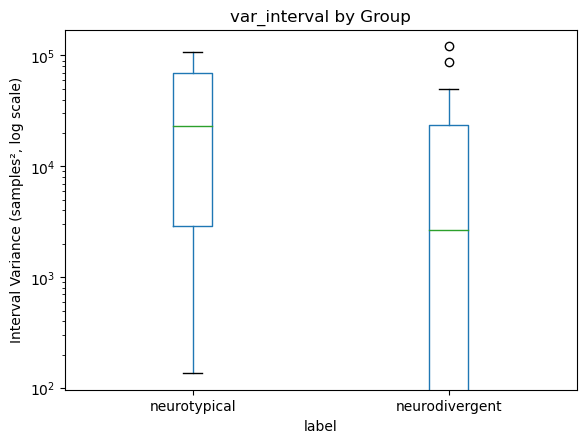

Medians:
label
0    23062.791667
1     2656.467456
Name: var_interval, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# boxplot on a log scale, since the variances spread wide
df_features.boxplot(column='var_interval',
                    by='label',
                    grid=False,
                    showfliers=True)
plt.yscale('log')
plt.xticks([1,2], ['neurotypical','neurodivergent'])
plt.ylabel('Interval Variance (samples², log scale)')
plt.title('var_interval by Group')
plt.suptitle('')
plt.show()

print("Medians:")
print(df_features.groupby('label')['var_interval'].median())


In [ ]:
rect = abs(sig.mean())
threshold = rect.mean() + 2*rect.std()
edges = rising_edges(rect > threshold)
intervals = diff(edges)


SyntaxError: invalid character '–' (U+2013) (453667729.py, line 1)

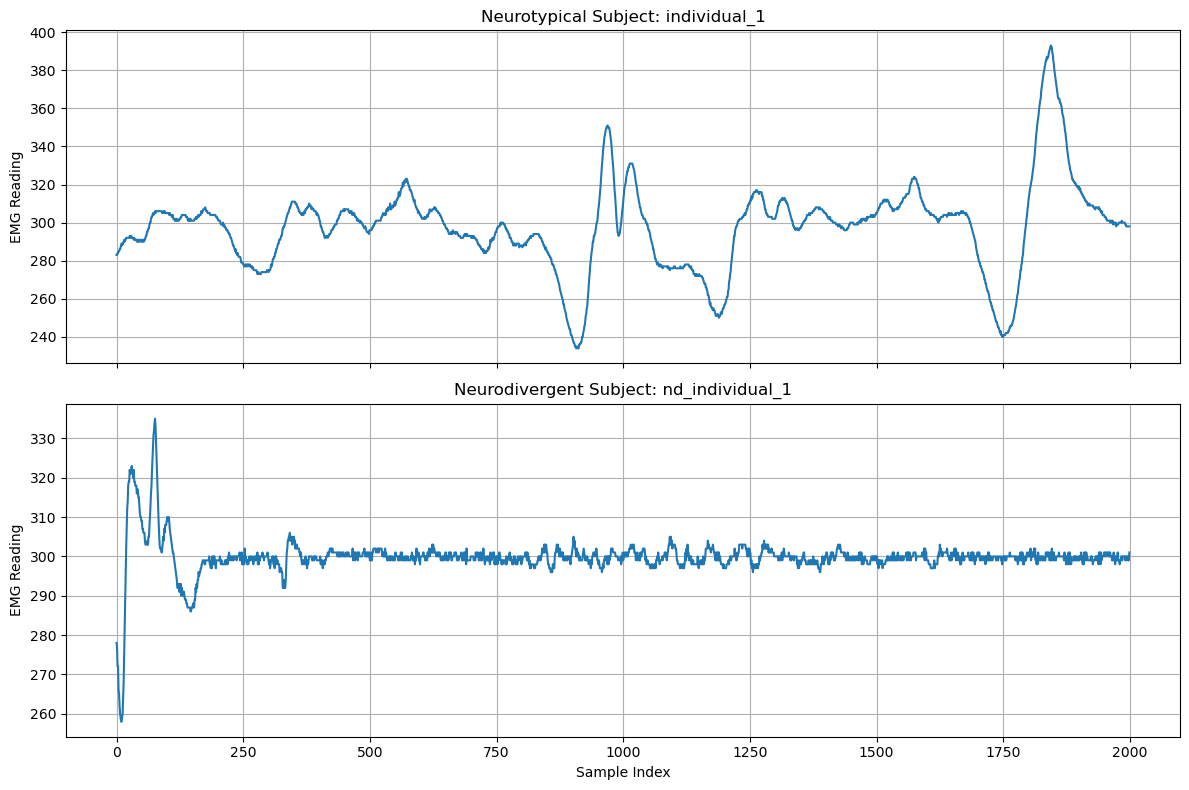

Plotted EMG signals for individual_1 (Neurotypical) and nd_individual_1 (Neurodivergent).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the combined_df is available from the previous execution
# If not, it would need to be reloaded using the previous code block.
# Assuming 'combined_df' exists in the environment.

# Select data for the specific subjects
subject_nt = 'individual_1' # Neurotypical example
subject_nd = 'nd_individual_1' # Neurodivergent example

df_nt = combined_df[combined_df['subject_id'] == subject_nt].reset_index()
df_nd = combined_df[combined_df['subject_id'] == subject_nd].reset_index()


# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True) # Two rows, one column

# Plot Neurotypical subject
axes[0].plot(df_nt.index, df_nt['EMG'])
axes[0].set_title(f'Neurotypical Subject: {subject_nt}')
axes[0].set_ylabel('EMG Reading')
axes[0].grid(True)


# Plot Neurodivergent subject
axes[1].plot(df_nd.index, df_nd['EMG'])
axes[1].set_title(f'Neurodivergent Subject: {subject_nd}')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('EMG Reading')
axes[1].grid(True)


plt.tight_layout()
plt.show()

print(f"Plotted EMG signals for {subject_nt} (Neurotypical) and {subject_nd} (Neurodivergent).")

Plotting Neurotypical subjects...
Plotting Neurodivergent subjects...


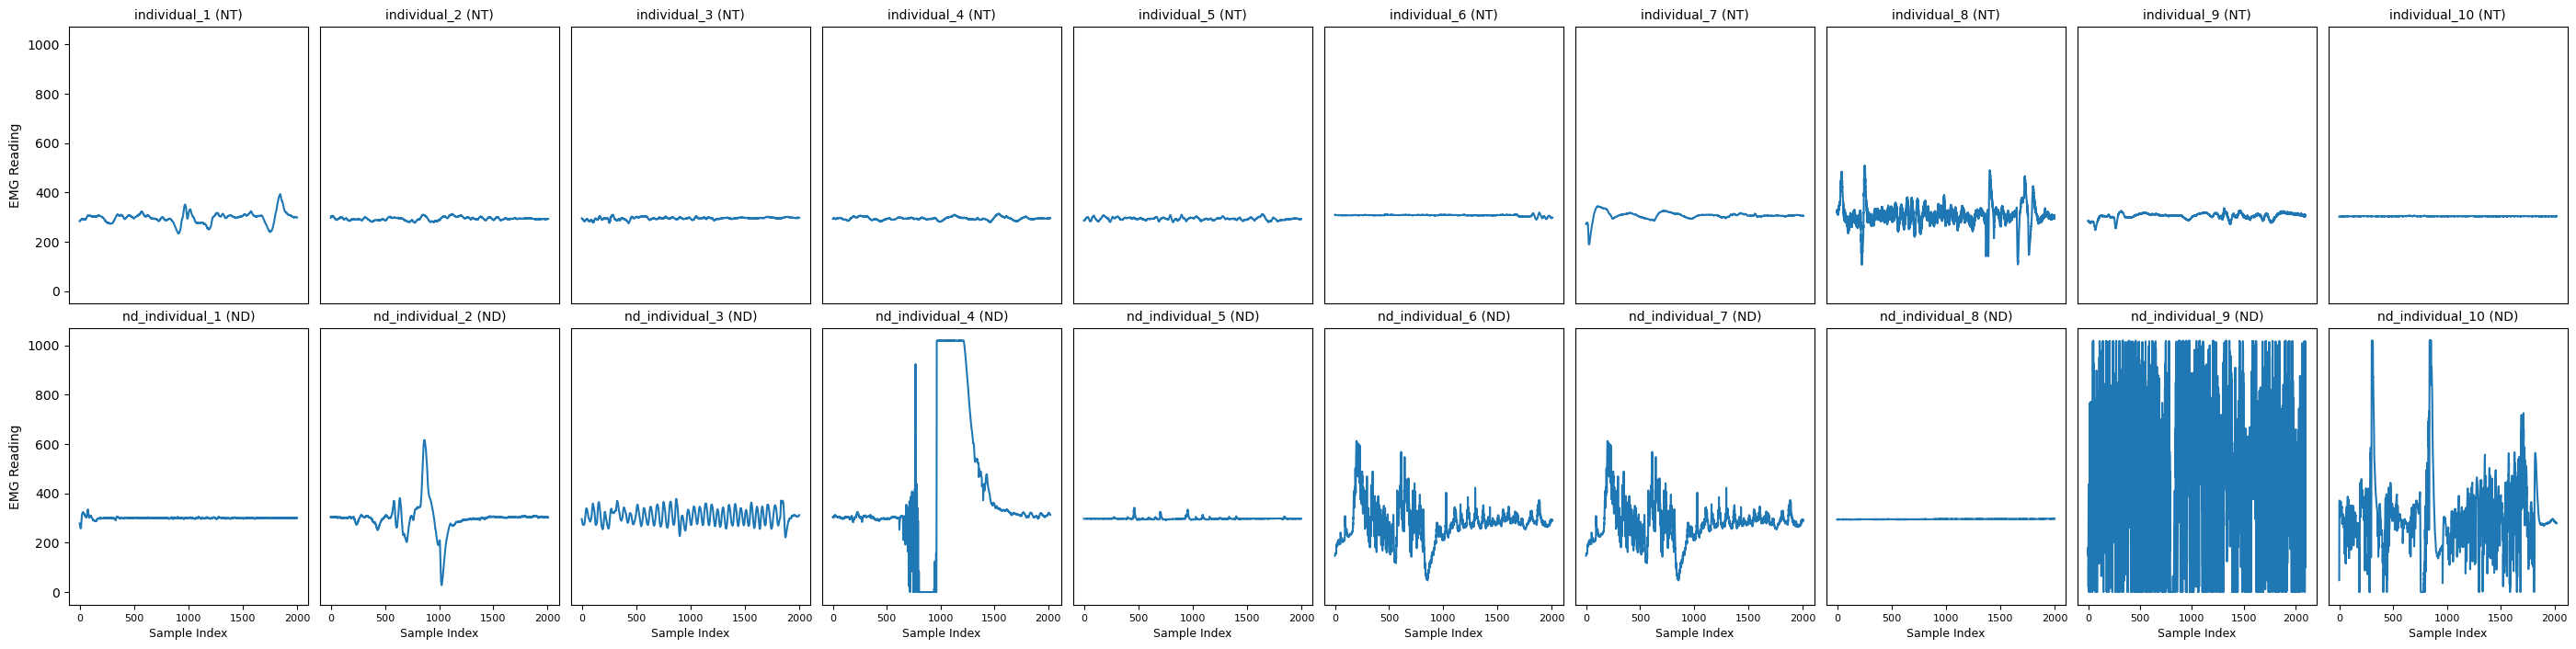

Displayed EMG signals for the first 10 subjects from each group in a 2x10 grid.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'combined_df' DataFrame exists from the previous execution.

# Select subjects to plot
nt_subjects = [f'individual_{i}' for i in range(1, 11)]
nd_subjects = [f'nd_individual_{i}' for i in range(1, 11)]

# Create figure and axes for a 2x10 grid
# Make figure wider to accommodate 10 plots per row
fig, axes = plt.subplots(2, 10, figsize=(28, 7), sharey=True) # Shared Y axis for easier comparison

# Plot Neurotypical subjects (Top Row)
print("Plotting Neurotypical subjects...")
for i, subject_id in enumerate(nt_subjects):
    ax = axes[0, i]
    df_subject = combined_df[combined_df['subject_id'] == subject_id].reset_index(drop=True)
    ax.plot(df_subject.index, df_subject['EMG'])
    ax.set_title(f'{subject_id} (NT)', fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Hide x-axis labels for top row
    if i == 0:
        ax.set_ylabel('EMG Reading')
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) # Hide y-axis labels for non-first plots

# Plot Neurodivergent subjects (Bottom Row)
print("Plotting Neurodivergent subjects...")
for i, subject_id in enumerate(nd_subjects):
    ax = axes[1, i]
    df_subject = combined_df[combined_df['subject_id'] == subject_id].reset_index(drop=True)
    ax.plot(df_subject.index, df_subject['EMG'])
    ax.set_title(f'{subject_id} (ND)', fontsize=10)
    ax.set_xlabel('Sample Index', fontsize=9)
    ax.tick_params(axis='x', labelsize=8) # Smaller x-axis labels
    if i == 0:
        ax.set_ylabel('EMG Reading')
    else:
         ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) # Hide y-axis labels for non-first plots

# Adjust layout and display
plt.tight_layout(pad=0.5) # Add a little padding
plt.show()

print("Displayed EMG signals for the first 10 subjects from each group in a 2x10 grid.")

Plotting Neurotypical subjects 11-20...
Plotting Neurodivergent subjects 11-20...


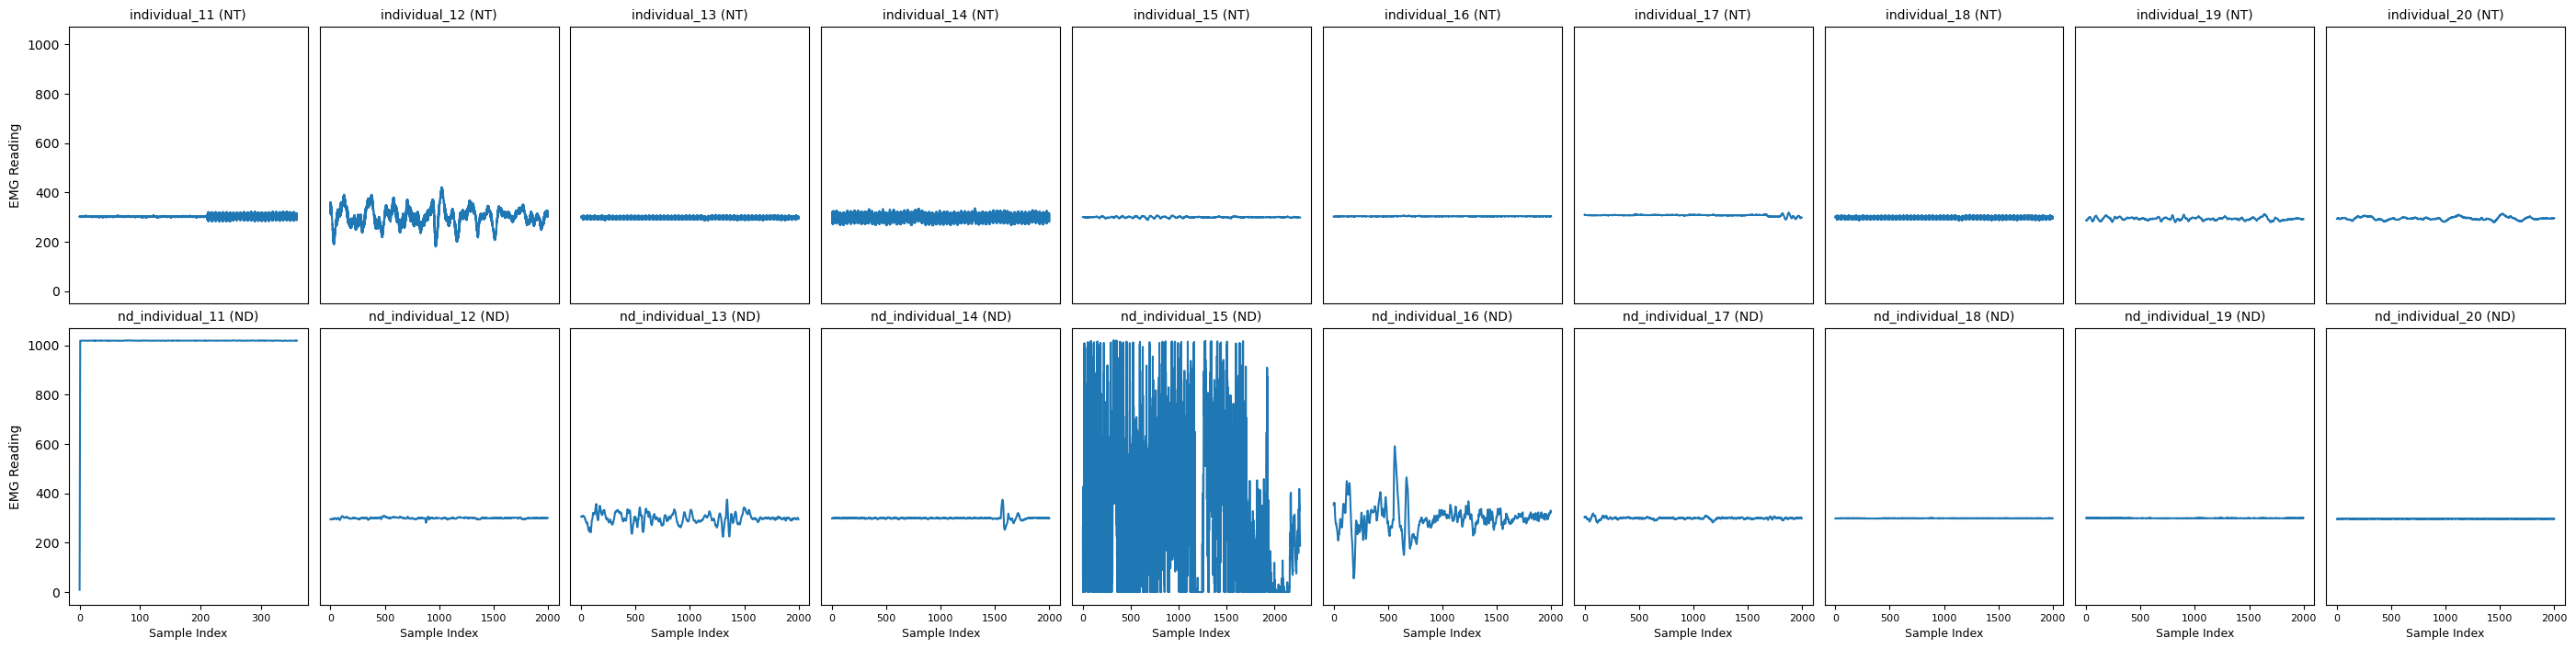

Displayed EMG signals for subjects 11-20 from each group in a 2x10 grid.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'combined_df' DataFrame exists from the previous execution.

# Select subjects to plot (next 10 from each group)
nt_subjects = [f'individual_{i}' for i in range(11, 21)]
nd_subjects = [f'nd_individual_{i}' for i in range(11, 21)]

# Create figure and axes for a 2x10 grid
fig, axes = plt.subplots(2, 10, figsize=(28, 7), sharey=True) # Shared Y axis

# Flatten axes array for easy iteration if needed, but direct indexing works for 2 rows
# axes = axes.flatten() # Not strictly needed for 2 rows

# Plot Neurotypical subjects (Top Row)
print("Plotting Neurotypical subjects 11-20...")
for i, subject_id in enumerate(nt_subjects):
    ax = axes[0, i]
    df_subject = combined_df[combined_df['subject_id'] == subject_id].reset_index(drop=True)
    if not df_subject.empty:
        ax.plot(df_subject.index, df_subject['EMG'])
        ax.set_title(f'{subject_id} (NT)', fontsize=10)
    else:
        ax.set_title(f'{subject_id} (NT)\nNo Data', fontsize=10) # Handle if data missing for some reason
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Hide x-axis labels for top row
    if i == 0:
        ax.set_ylabel('EMG Reading')
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) # Hide y-axis labels for non-first plots

# Plot Neurodivergent subjects (Bottom Row)
print("Plotting Neurodivergent subjects 11-20...")
for i, subject_id in enumerate(nd_subjects):
    ax = axes[1, i]
    df_subject = combined_df[combined_df['subject_id'] == subject_id].reset_index(drop=True)
    if not df_subject.empty:
        ax.plot(df_subject.index, df_subject['EMG'])
        ax.set_title(f'{subject_id} (ND)', fontsize=10)
    else:
         ax.set_title(f'{subject_id} (ND)\nNo Data', fontsize=10)
    ax.set_xlabel('Sample Index', fontsize=9)
    ax.tick_params(axis='x', labelsize=8) # Smaller x-axis labels
    if i == 0:
        ax.set_ylabel('EMG Reading')
    else:
         ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) # Hide y-axis labels for non-first plots

# Adjust layout and display
plt.tight_layout(pad=0.5) # Add a little padding
plt.show()

print("Displayed EMG signals for subjects 11-20 from each group in a 2x10 grid.")

Plotting remaining Neurodivergent subjects 21-23...


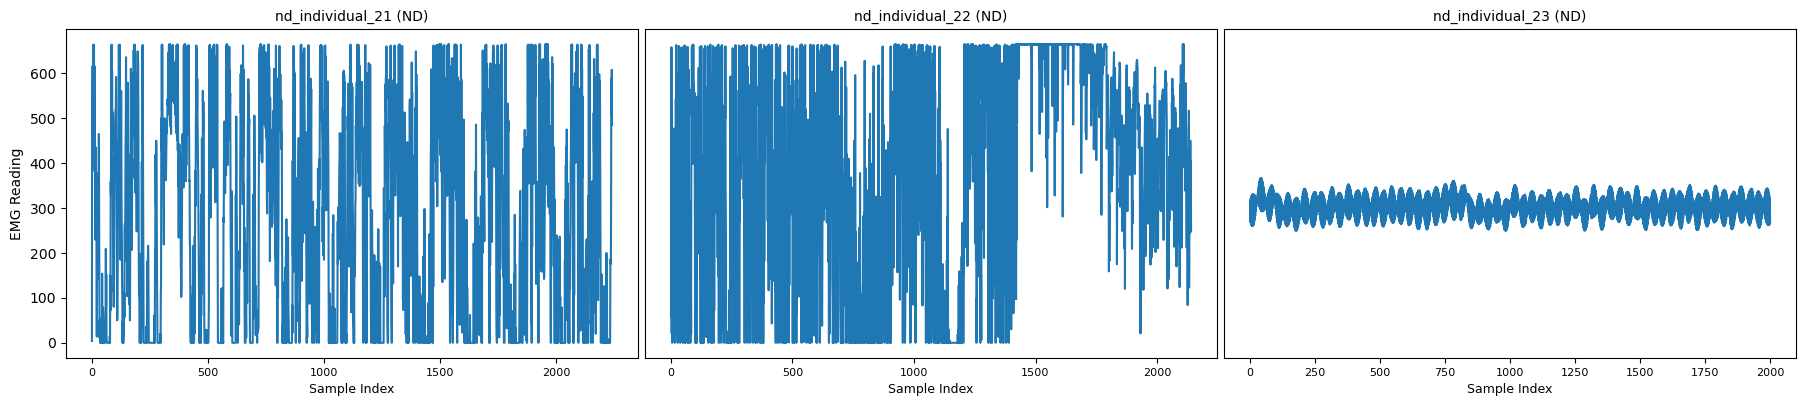

Displayed EMG signals for the remaining 3 neurodivergent subjects.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'combined_df' DataFrame exists from the previous execution.

# Select the remaining neurodivergent subjects
nd_subjects_remaining = [f'nd_individual_{i}' for i in range(21, 24)] # Subjects 21, 22, 23

# Create figure and axes for a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True) # Shared Y axis

# Plot data for each selected subject
print("Plotting remaining Neurodivergent subjects 21-23...")
for i, subject_id in enumerate(nd_subjects_remaining):
    ax = axes[i]
    df_subject = combined_df[combined_df['subject_id'] == subject_id].reset_index(drop=True)
    if not df_subject.empty:
        ax.plot(df_subject.index, df_subject['EMG'])
        ax.set_title(f'{subject_id} (ND)', fontsize=10)
    else:
         ax.set_title(f'{subject_id} (ND)\nNo Data', fontsize=10)
    ax.set_xlabel('Sample Index', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    if i == 0:
        ax.set_ylabel('EMG Reading')
    else:
         ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) # Hide y-axis labels for non-first plots

# Adjust layout and display
plt.tight_layout(pad=0.5)
plt.show()

print("Displayed EMG signals for the remaining 3 neurodivergent subjects.")

Calculating summary statistics per subject...

Summary statistics per subject (first 5 rows):
      subject_id  group      mean        std  min  max         rms
0   individual_1      0  297.7165  22.956974  234  393  298.599855
1  individual_10      0  303.4485   0.608714  301  305  303.449110
2  individual_11      0  302.3820   8.236747  282  322  302.494106
3  individual_12      0  301.2925  37.688767  180  421  303.639430
4  individual_13      0  297.8170   6.138921  286  309  297.880233

Total subjects with stats: 43

Generating box plots for group comparison...


e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-package

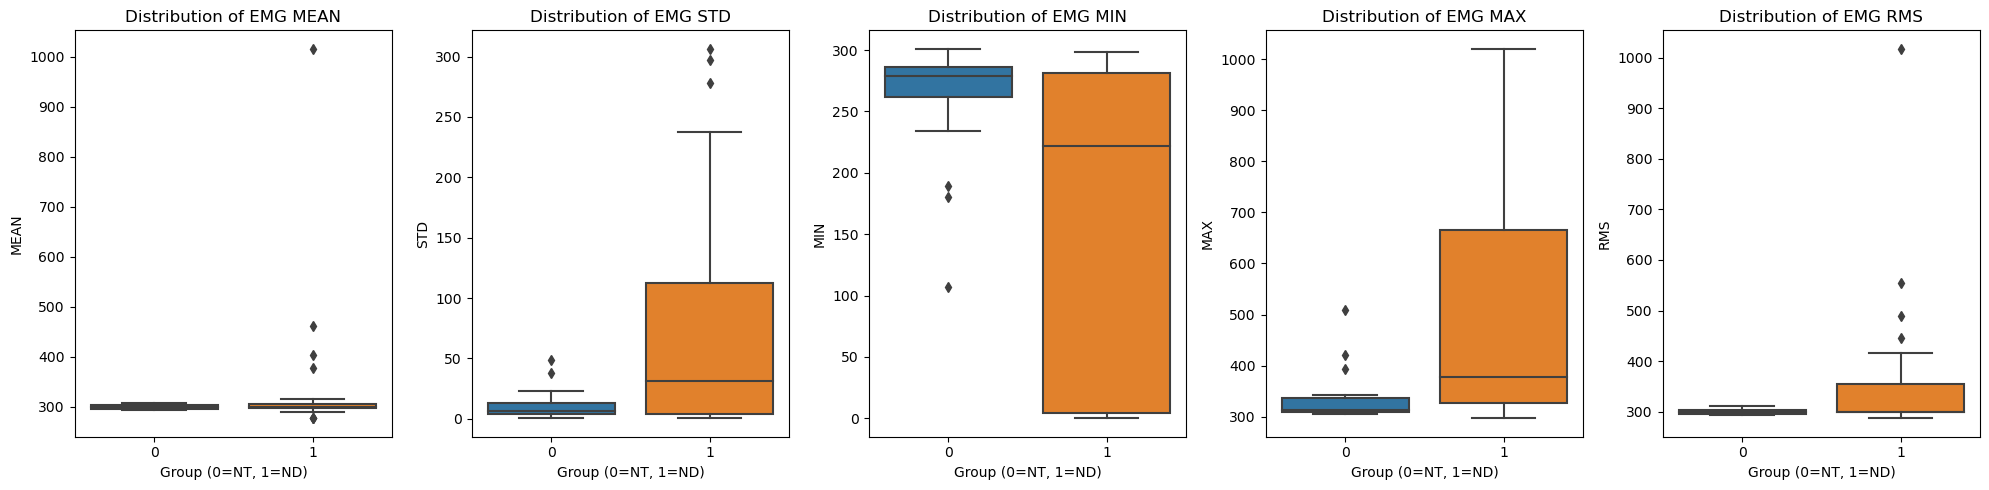


Displayed box plots comparing distributions of summary statistics between groups.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' DataFrame exists from the previous execution.

# Define function for RMS calculation
def rms(x):
    return np.sqrt(np.mean(x**2))

print("Calculating summary statistics per subject...")
# Group by subject and group, then calculate aggregate statistics
subject_stats_df = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    rms=rms
).reset_index()

print("\nSummary statistics per subject (first 5 rows):")
print(subject_stats_df.head())
print(f"\nTotal subjects with stats: {len(subject_stats_df)}")


# --- Plotting the distributions ---
print("\nGenerating box plots for group comparison...")

stats_to_plot = ['mean', 'std', 'min', 'max', 'rms']
fig, axes = plt.subplots(1, len(stats_to_plot), figsize=(20, 5))

for i, stat in enumerate(stats_to_plot):
    sns.boxplot(ax=axes[i], x='group', y=stat, data=subject_stats_df)
    axes[i].set_title(f'Distribution of EMG {stat.upper()}')
    axes[i].set_xlabel('Group (0=NT, 1=ND)')
    axes[i].set_ylabel(stat.upper())

plt.tight_layout()
plt.show()

print("\nDisplayed box plots comparing distributions of summary statistics between groups.")

Using test_size=0.20
Training set size: 34 samples
Testing set size: 9 samples
Training set group distribution:
group
1    0.529412
0    0.470588
Name: proportion, dtype: float64
Testing set group distribution:
group
1    0.555556
0    0.444444
Name: proportion, dtype: float64

Model trained using Logistic Regression.

Model Accuracy on Test Set: 0.8889

Classification Report:
                    precision    recall  f1-score   support

  Neurotypical (0)       0.80      1.00      0.89         4
Neurodivergent (1)       1.00      0.80      0.89         5

          accuracy                           0.89         9
         macro avg       0.90      0.90      0.89         9
      weighted avg       0.91      0.89      0.89         9


Confusion Matrix:
[[4 0]
 [1 4]]


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

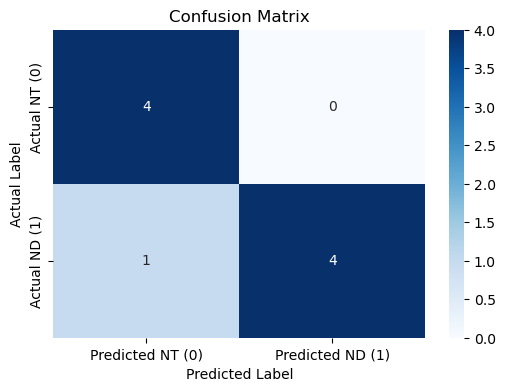

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'subject_stats_df' DataFrame exists from the previous execution.
# It contains ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms']

# 1. Prepare Data
features = ['mean', 'std', 'min', 'max', 'rms']
X = subject_stats_df[features]
y = subject_stats_df['group']

# 2. Split Data (80% train, 20% test, stratified)
# Ensure at least 1 sample per class in test set if dataset is very small
test_size = 0.2
# Calculate minimum samples needed for test set based on smallest class size
min_class_count = y.value_counts().min()
# Ensure test size doesn't lead to less than 1 sample per class in test split
if int(min_class_count * test_size) < 1:
     # Adjust test_size to ensure at least 1 sample per class, or handle error
     # For simplicity here, we might need a larger dataset or different validation like cross-validation
     # Let's try a slightly larger test set if needed, or adjust based on minimum count
     if min_class_count > 1: # Need at least 2 samples in smallest class to split
       test_size = 1 / min_class_count # Ensure at least 1 sample in test set
     else:
       # Cannot perform stratified split with only 1 sample in a class
       print("Warning: Smallest class has only 1 sample. Cannot guarantee stratified split.")
       # Fallback or error handling needed - for now, proceed cautiously
       test_size = 0.2 # Keep original if fallback not defined

# Check again if test_size is reasonable
if test_size >= 0.5 and min_class_count <=2 : # Avoid tiny training sets
    print(f"Warning: Adjusted test size ({test_size:.2f}) is large due to small class size. Consider cross-validation.")
    # Maybe cap test_size
    test_size = 0.4

print(f"Using test_size={test_size:.2f}")

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42, # for reproducibility
        stratify=y      # keep group proportions in train/test
    )
except ValueError as e:
     print(f"Error during train_test_split (likely due to small dataset/class size): {e}")
     print("Attempting split without stratification...")
     # Fallback to non-stratified split if stratification fails (not ideal)
     X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42
    )


print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set group distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing set group distribution:\n{y_test.value_counts(normalize=True)}")


# 3. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use transform only, no fitting on test data

# 4. Choose & Train Model (Logistic Regression)
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
print("\nModel trained using Logistic Regression.")

# 5. Evaluate Model
y_pred = model.predict(X_test_scaled)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy on Test Set: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Neurotypical (0)', 'Neurodivergent (1)']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NT (0)', 'Predicted ND (1)'],
            yticklabels=['Actual NT (0)', 'Actual ND (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Assuming 'subject_stats_df' DataFrame exists from the previous execution.
# It contains ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms']

# Prepare Data
features = ['mean', 'std', 'min', 'max', 'rms']
X = subject_stats_df[features]
y = subject_stats_df['group']

# Create a pipeline: Scale features then apply Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, C=1.0)) # Using default C=1.0
])

# Define Cross-Validation strategy (Stratified K-Fold with 5 splits)
# Shuffle ensures random distribution of data before splitting into folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-Fold Stratified Cross-Validation...")

# Perform cross-validation
# 'scoring' is set to 'accuracy' by default
try:
    cv_scores = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring='accuracy')

    # Print results
    print(f"\nCross-Validation Accuracy Scores for each fold: {cv_scores}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
    print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.4f}")

except ValueError as e:
     print(f"\nError during cross-validation: {e}")
     print("This might happen if a fold ends up with only one class due to small dataset size.")
     # Suggest trying LeaveOneOut as an alternative for very small datasets
     from sklearn.model_selection import LeaveOneOut, cross_val_score
     loo = LeaveOneOut()
     print("\nAttempting Leave-One-Out Cross-Validation instead...")
     try:
        cv_scores_loo = cross_val_score(pipeline, X, y, cv=loo, scoring='accuracy')
        print(f"\nLeave-One-Out CV Mean Accuracy: {np.mean(cv_scores_loo):.4f}")
        print(f"(Tested on each of the {len(cv_scores_loo)} subjects individually)")
     except Exception as loo_e:
        print(f"Leave-One-Out Cross-Validation also failed: {loo_e}")

Running 5-Fold Stratified Cross-Validation...

Cross-Validation Accuracy Scores for each fold: [0.55555556 0.55555556 0.88888889 0.625      0.625     ]
Mean CV Accuracy: 0.6500
Standard Deviation of CV Accuracy: 0.1234


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

Calculating Waveform Length (WL) per subject...

Waveform Length added/updated in subject statistics (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524
3  individual_12      0  301.2925  37.688767  180  421  303.639430  45661
4  individual_13      0  297.8170   6.138921  286  309  297.880233  21793

Generating box plot for Waveform Length (WL) group comparison...


e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


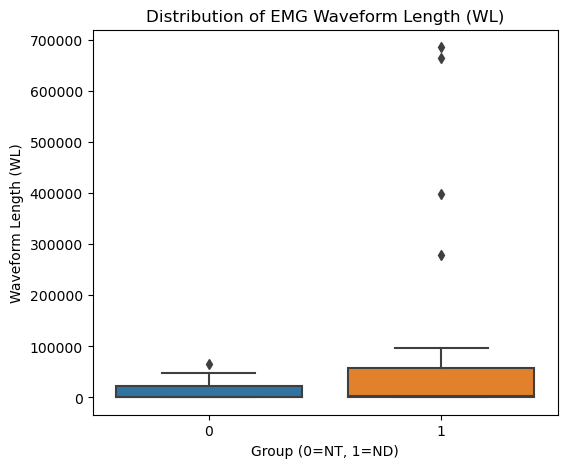


Displayed box plot comparing Waveform Length distributions between groups.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'combined_df' DataFrame exists from the previous execution.
# Assuming 'subject_stats_df' DataFrame also exists from the stats calculation.

# Define function for Waveform Length calculation
def waveform_length(x):
    # Ensure x is treated as a numerical array
    # Use .values to get numpy array from pandas Series passed by agg
    return np.sum(np.abs(np.diff(x.values)))

print("Calculating Waveform Length (WL) per subject...")
# Group by subject and group, then calculate WL
try:
    wl_stats = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
        wl=waveform_length
    ).reset_index()

    # Merge/update with previous stats (optional, but keeps features together)
    # Check if subject_stats_df exists in the environment
    if 'subject_stats_df' in locals() or 'subject_stats_df' in globals():
        # Ensure no duplicate columns if run multiple times
        if 'wl' not in subject_stats_df.columns:
            # If 'wl' column doesn't exist, merge wl_stats into subject_stats_df
            subject_stats_df = pd.merge(subject_stats_df, wl_stats, on=['subject_id', 'group'], how='left')
        else:
            # If 'wl' column exists, update it with new values from wl_stats
            # Set index for efficient update based on subject and group
            subject_stats_df = subject_stats_df.set_index(['subject_id', 'group'])
            wl_stats_indexed = wl_stats.set_index(['subject_id', 'group'])
            subject_stats_df.update(wl_stats_indexed)
            subject_stats_df = subject_stats_df.reset_index() # Reset index after update

        # Use the potentially updated DataFrame for display and plotting
        display_df = subject_stats_df
        print("\nWaveform Length added/updated in subject statistics (first 5 rows):")
        print(display_df.head())

    else:
        # If subject_stats_df wasn't found, just use the newly calculated wl_stats
        display_df = wl_stats
        print("\nWaveform Length per subject (first 5 rows):")
        print(display_df.head())


    # --- Plotting the distribution of Waveform Length ---
    print("\nGenerating box plot for Waveform Length (WL) group comparison...")

    plt.figure(figsize=(6, 5))
    sns.boxplot(x='group', y='wl', data=display_df)
    plt.title('Distribution of EMG Waveform Length (WL)')
    plt.xlabel('Group (0=NT, 1=ND)')
    plt.ylabel('Waveform Length (WL)')
    plt.show()

    print("\nDisplayed box plot comparing Waveform Length distributions between groups.")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the 'combined_df' DataFrame is correctly loaded.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns # Keep seaborn imported for potential future plots

# Assuming 'subject_stats_df' DataFrame exists and includes the 'wl' column.
# If not, the code from the previous step to calculate and merge 'wl' would need to be rerun first.

# Check if 'wl' column exists, if not, recalculate (optional, defensive coding)
if 'subject_stats_df' not in locals() or 'subject_stats_df' not in globals() or 'wl' not in subject_stats_df.columns:
    print("Recalculating Waveform Length as subject_stats_df was not found or missing 'wl'.")
    # Assuming 'combined_df' exists
    if 'combined_df' in locals() or 'combined_df' in globals():
        def waveform_length(x):
            return np.sum(np.abs(np.diff(x.values)))
        wl_stats = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(wl=waveform_length).reset_index()
        # Need to define base subject_stats_df if it doesn't exist
        subject_stats_df = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
            mean='mean', std='std', min='min', max='max', rms=lambda x: np.sqrt(np.mean(x**2))
        ).reset_index()
        subject_stats_df = pd.merge(subject_stats_df, wl_stats, on=['subject_id', 'group'], how='left')
        print("Recalculation complete.")
    else:
        print("Error: Cannot proceed without 'combined_df'. Please ensure data is loaded.")
        # Exit or raise error if combined_df is essential and missing
        raise ValueError("Combined DataFrame not found.")


# 1. Prepare Data with WL included
features = ['mean', 'std', 'min', 'max', 'rms', 'wl'] # Added 'wl'
X = subject_stats_df[features]
y = subject_stats_df['group']

# 2. Create Pipeline (Scaler + Classifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, C=1.0)) # Using default C=1.0
])

# 3. Define Cross-Validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-Fold Stratified Cross-Validation with WL feature included...")

# 4. Perform cross-validation
try:
    cv_scores_wl = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring='accuracy')

    # 5. Print results
    print(f"\nCross-Validation Accuracy Scores with WL: {cv_scores_wl}")
    print(f"Mean CV Accuracy with WL: {np.mean(cv_scores_wl):.4f}")
    print(f"Standard Deviation of CV Accuracy with WL: {np.std(cv_scores_wl):.4f}")

except ValueError as e:
     print(f"\nError during cross-validation: {e}")
     # Fallback to LeaveOneOut if needed (code omitted for brevity, same as before)
     print("Consider using LeaveOneOut cross-validation for very small datasets if errors persist.")

Running 5-Fold Stratified Cross-Validation with WL feature included...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages


Cross-Validation Accuracy Scores with WL: [0.55555556 0.44444444 0.88888889 0.625      0.625     ]
Mean CV Accuracy with WL: 0.6278
Standard Deviation of CV Accuracy with WL: 0.1463


In [ ]:
import pandas as pd
import numpy as np

# Assuming 'combined_df' DataFrame exists.
# Assuming 'subject_stats_df' DataFrame exists from the initial stats calculation.

# Define function for Waveform Length calculation
def waveform_length(x):
    # Ensure x is treated as a numerical array
    return np.sum(np.abs(np.diff(x.values)))

print("Calculating Waveform Length (WL) per subject...")
try:
    # Calculate WL grouped by subject and group
    wl_stats = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
        wl=waveform_length
    ).reset_index()
    print("WL calculation successful.")

    # Check if subject_stats_df exists and update/merge WL into it
    if 'subject_stats_df' in locals() or 'subject_stats_df' in globals():
        print("Merging WL into existing subject_stats_df...")

        # Ensure subject_stats_df has standard columns if previously indexed
        if 'subject_id' not in subject_stats_df.columns:
             subject_stats_df = subject_stats_df.reset_index()

        # Remove old 'wl' column if it exists from a previous run to avoid duplicate columns
        if 'wl' in subject_stats_df.columns:
            subject_stats_df = subject_stats_df.drop(columns=['wl'])

        # Merge the new WL stats based on subject_id and group
        subject_stats_df = pd.merge(subject_stats_df, wl_stats, on=['subject_id', 'group'], how='left')
        print("Merge successful.")

    else:
        # If subject_stats_df somehow doesn't exist, create it just with WL
        # This shouldn't happen based on our workflow, but as a fallback:
        print("Warning: subject_stats_df not found, creating new one with only WL.")
        subject_stats_df = wl_stats

    print("\nUpdated subject statistics including Waveform Length (first 5 rows):")
    # Display relevant columns including the new 'wl' feature
    print(subject_stats_df[['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl']].head())

    # Verify WL column
    if 'wl' in subject_stats_df.columns and subject_stats_df['wl'].notna().all():
        print(f"\nSuccessfully added 'wl' feature for all {len(subject_stats_df)} subjects.")
    else:
        print("\nError: Problem adding or verifying 'wl' column.")

except Exception as e:
    print(f"An error occurred during WL calculation or merge: {e}")

Calculating Waveform Length (WL) per subject...
WL calculation successful.
Merging WL into existing subject_stats_df...
Merge successful.

Updated subject statistics including Waveform Length (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524
3  individual_12      0  301.2925  37.688767  180  421  303.639430  45661
4  individual_13      0  297.8170   6.138921  286  309  297.880233  21793

Successfully added 'wl' feature for all 43 subjects.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'subject_stats_df' DataFrame exists and now includes the 'wl' column.

# Prepare Data with the new feature included
features = ['mean', 'std', 'min', 'max', 'rms', 'wl'] # Added 'wl'
X = subject_stats_df[features]
y = subject_stats_df['group']

print(f"Using features: {features}")

# Create a pipeline: Scale features then apply Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, C=1.0, max_iter=1000)) # Increased max_iter just in case
])

# Define Cross-Validation strategy (Stratified K-Fold with 5 splits)
# Using the same random_state for reproducibility of splits
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning 5-Fold Stratified Cross-Validation with WL included...")

# Perform cross-validation for multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

cv_results = {}
try:
    # Calculate scores for each metric
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(pipeline, X, y, cv=cv_strategy, scoring=scorer)
        cv_results[metric_name] = scores
        print(f"  {metric_name.capitalize()} scores per fold: {scores}")
        print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


    # Print overall summary
    print("\nCross-Validation Summary (with WL feature):")
    for metric_name, scores in cv_results.items():
      print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


except ValueError as e:
     print(f"\nError during cross-validation: {e}")
     print("This might happen if a fold ends up with only one class due to small dataset size.")
     # Suggest trying LeaveOneOut as an alternative for very small datasets
     from sklearn.model_selection import LeaveOneOut, cross_val_score
     loo = LeaveOneOut()
     print("\nAttempting Leave-One-Out Cross-Validation instead...")
     try:
        cv_scores_loo_acc = cross_val_score(pipeline, X, y, cv=loo, scoring='accuracy')
        print(f"\nLeave-One-Out CV Mean Accuracy: {np.mean(cv_scores_loo_acc):.4f}")
        print(f"(Tested on each of the {len(cv_scores_loo_acc)} subjects individually)")
     except Exception as loo_e:
        print(f"Leave-One-Out Cross-Validation also failed: {loo_e}")
except Exception as e:
    print(f"An unexpected error occurred during cross-validation: {e}")

Using features: ['mean', 'std', 'min', 'max', 'rms', 'wl']

Running 5-Fold Stratified Cross-Validation with WL included...
  Accuracy scores per fold: [0.55555556 0.44444444 0.88888889 0.625      0.625     ]
  Mean Accuracy: 0.6278 (+/- 0.1463)
  Precision_macro scores per fold: [0.55       0.22222222 0.9        0.63333333 0.78571429]
  Mean Precision_macro: 0.6183 (+/- 0.2320)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Recall_macro scores per fold: [0.55  0.5   0.9   0.625 0.625]
  Mean Recall_macro: 0.6400 (+/- 0.1384)
  F1_macro scores per fold: [0.55       0.30769231 0.88888889 0.61904762 0.56363636]
  Mean F1_macro: 0.5859 (+/- 0.1855)

Cross-Validation Summary (with WL feature):
  Mean Accuracy: 0.6278 (+/- 0.1463)
  Mean Precision_macro: 0.6183 (+/- 0.2320)
  Mean Recall_macro: 0.6400 (+/- 0.1384)
  Mean F1_macro: 0.5859 (+/- 0.1855)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

Using features: ['mean', 'std', 'min', 'max', 'rms', 'wl']
Features scaled.

Training Random Forest model...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

Model training complete.
Model Out-of-Bag (OOB) estimated accuracy: 0.7674

Feature Importances:
  feature  importance
3     max    0.280266
1     std    0.221884
2     min    0.168998
0    mean    0.125685
4     rms    0.104706
5      wl    0.098461


e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


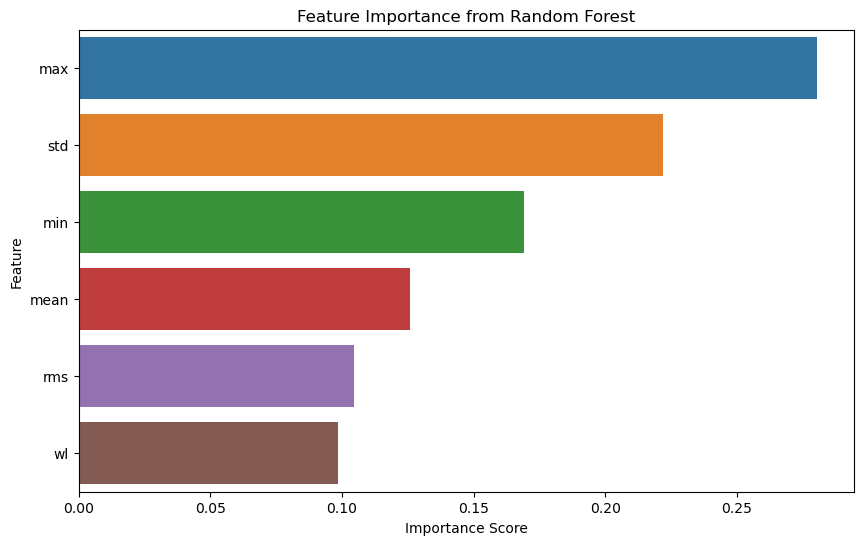

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Assuming 'subject_stats_df' DataFrame exists and contains the 'wl' column.

# Prepare Data using all 6 features
features = ['mean', 'std', 'min', 'max', 'rms', 'wl']
X = subject_stats_df[features]
y = subject_stats_df['group']

print(f"Using features: {features}")

# Scale features (Good practice even for Random Forest, ensures consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# Initialize and train Random Forest Classifier
# Using the entire dataset to get overall feature importances for this dataset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True) # Use oob_score for an estimate of generalization
print("\nTraining Random Forest model...")
rf_model.fit(X_scaled, y)
print("Model training complete.")
print(f"Model Out-of-Bag (OOB) estimated accuracy: {rf_model.oob_score_:.4f}")


# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

Features used for Random Forest: ['mean', 'std', 'min', 'max', 'rms', 'wl']
Features scaled.
Training Random Forest model on all data...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

Model training complete.

Feature Importances:
  Feature  Importance
3     max    0.280266
1     std    0.221884
2     min    0.168998
0    mean    0.125685
4     rms    0.104706
5      wl    0.098461


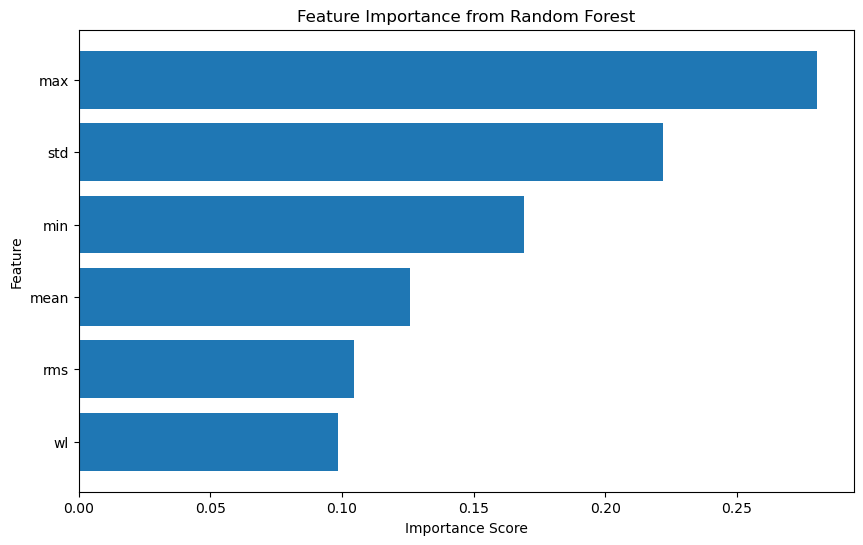

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Assuming 'subject_stats_df' DataFrame exists and contains 'wl' along with other stats.

# Prepare Data
features = ['mean', 'std', 'min', 'max', 'rms', 'wl']
X = subject_stats_df[features]
y = subject_stats_df['group']

print(f"Features used for Random Forest: {features}")

# Scale features (Good practice, though less critical for Random Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# Initialize and train Random Forest model
# Using n_estimators=100 and random_state for reproducibility
# Training on the entire dataset to get overall feature importances for this specific dataset
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=False) # oob_score=False if not needed now

print("Training Random Forest model on all data...")
rf_model.fit(X_scaled, y)
print("Model training complete.")

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'combined_df' DataFrame exists from the loading step.
# Assuming 'subject_stats_df' DataFrame exists from the initial stats calculation (mean, std, min, max, rms).

# Define function for Waveform Length calculation
def waveform_length(x):
    # Ensure x is treated as a numerical array
    return np.sum(np.abs(np.diff(x.values)))

print("Calculating Waveform Length (WL) per subject...")
try:
    # Calculate WL grouped by subject and group
    wl_stats = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
        wl=waveform_length
    ).reset_index()
    print("WL calculation successful.")

    # Check if subject_stats_df exists and update/merge WL into it
    # Use 'globals()' or 'locals()' check to see if the variable is defined
    if 'subject_stats_df' in globals() or 'subject_stats_df' in locals():
        print("Merging WL into existing subject_stats_df...")

        # Reset index if it was set previously during updates
        if not isinstance(subject_stats_df.index, pd.RangeIndex):
             subject_stats_df = subject_stats_df.reset_index()

        # Ensure key columns exist if df was manipulated
        if 'subject_id' not in subject_stats_df.columns or 'group' not in subject_stats_df.columns:
             # This case indicates subject_stats_df might be corrupted, handle appropriately
             # For simplicity, we might recreate or raise an error. Here we'll try resetting index if possible
             # Or recreate if absolutely necessary
             print("Warning: subject_stats_df missing key columns, attempting recovery or using only WL.")
             # If subject_id and group are in index, reset it:
             if 'subject_id' in subject_stats_df.index.names and 'group' in subject_stats_df.index.names:
                 subject_stats_df = subject_stats_df.reset_index()
             else:
                 # Cannot reliably merge, use only wl_stats or recompute all stats
                 print("Error: Cannot reliably merge WL. Previous stats might be lost.")
                 subject_stats_df = wl_stats # Fallback to only WL


        # Remove old 'wl' column if it exists from a previous run to avoid duplicate columns
        if 'wl' in subject_stats_df.columns:
            print("Removing existing 'wl' column before merging.")
            subject_stats_df = subject_stats_df.drop(columns=['wl'])

        # Merge the new WL stats based on subject_id and group
        # Ensure keys exist before merging
        if 'subject_id' in subject_stats_df.columns and 'group' in subject_stats_df.columns:
            subject_stats_df = pd.merge(subject_stats_df, wl_stats, on=['subject_id', 'group'], how='left')
            print("Merge successful.")
        else:
             print("Error: Could not merge WL due to missing key columns in subject_stats_df.")
             # Handle error - maybe stop, or proceed using only wl_stats if appropriate
             # For now, let's allow it to potentially fail later if subject_stats_df is bad
             pass


    else:
        # If subject_stats_df somehow doesn't exist, create it just with WL
        print("Warning: subject_stats_df not found, creating new one with only WL.")
        subject_stats_df = wl_stats # Assign wl_stats to subject_stats_df


    # Final check and display
    if 'wl' in subject_stats_df.columns and subject_stats_df['wl'].notna().all():
        print(f"\nSuccessfully added/updated 'wl' feature for all {len(subject_stats_df)} subjects.")
        # Display relevant columns including the new 'wl' feature
        cols_to_show = ['subject_id', 'group'] + [col for col in ['mean', 'std', 'min', 'max', 'rms', 'wl'] if col in subject_stats_df.columns]
        print("\nCurrent subject statistics (first 5 rows):")
        print(subject_stats_df[cols_to_show].head())

    else:
        print("\nError: Problem adding or verifying 'wl' column.")
        if 'wl' in subject_stats_df.columns:
             print(f"Number of missing WL values: {subject_stats_df['wl'].isna().sum()}")


except Exception as e:
    print(f"An error occurred during WL calculation or merge: {e}")

Calculating Waveform Length (WL) per subject...
WL calculation successful.
Merging WL into existing subject_stats_df...
Removing existing 'wl' column before merging.
Merge successful.

Successfully added/updated 'wl' feature for all 43 subjects.

Current subject statistics (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524
3  individual_12      0  301.2925  37.688767  180  421  303.639430  45661
4  individual_13      0  297.8170   6.138921  286  309  297.880233  21793


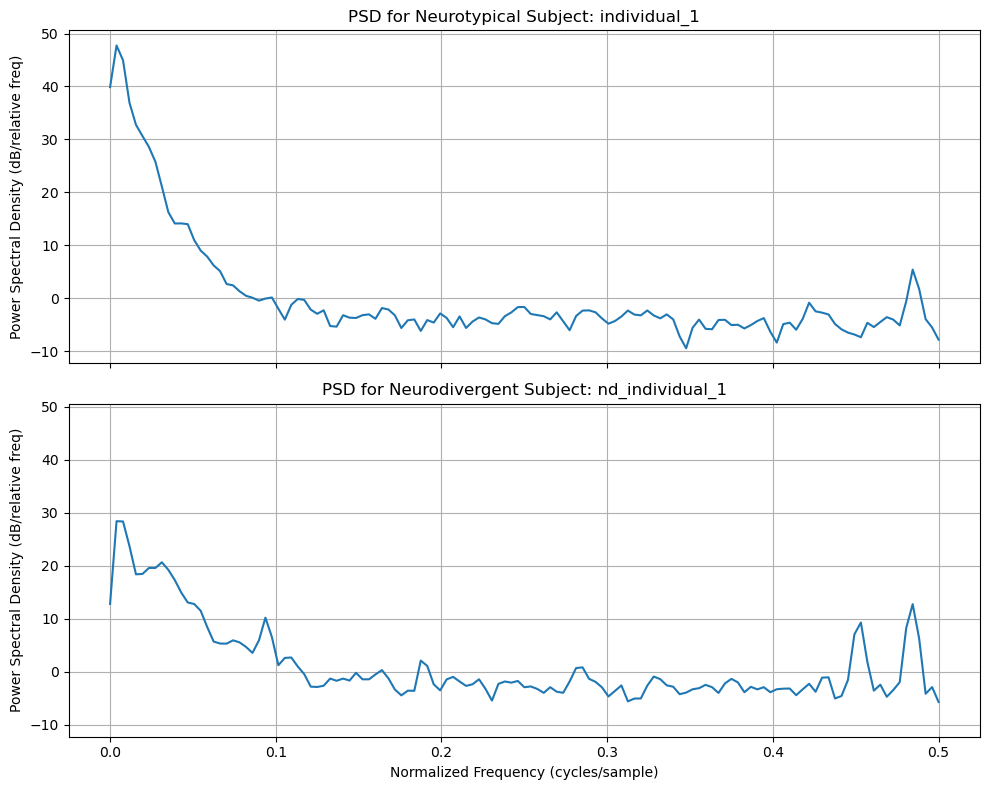


Displayed Power Spectral Density (PSD) plots.
Note: Frequency axis is normalized (cycles/sample) as actual sampling rate is unknown.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Assuming 'combined_df' DataFrame exists from the loading step.

# Select data for the specific subjects
subject_nt = 'individual_1' # Neurotypical example
subject_nd = 'nd_individual_1' # Neurodivergent example

try:
    sig_nt = combined_df[combined_df['subject_id'] == subject_nt]['EMG'].values
    sig_nd = combined_df[combined_df['subject_id'] == subject_nd]['EMG'].values

    # Calculate PSD using Welch's method
    # Since Fs is unknown, we'll use fs=1.0. The frequency axis will be in cycles/sample (relative).
    # We can adjust nperseg for resolution vs variance trade-off. Let's use 256 as a default.
    fs = 1.0 # Placeholder since actual Fs is unknown
    nperseg_val = 256 # Window size for Welch method

    if len(sig_nt) >= nperseg_val:
        freq_nt, psd_nt = signal.welch(sig_nt, fs=fs, nperseg=nperseg_val)
    else:
        print(f"Warning: Signal length for {subject_nt} ({len(sig_nt)}) is less than nperseg ({nperseg_val}). Skipping PSD calculation.")
        freq_nt, psd_nt = None, None

    if len(sig_nd) >= nperseg_val:
       freq_nd, psd_nd = signal.welch(sig_nd, fs=fs, nperseg=nperseg_val)
    else:
        print(f"Warning: Signal length for {subject_nd} ({len(sig_nd)}) is less than nperseg ({nperseg_val}). Skipping PSD calculation.")
        freq_nd, psd_nd = None, None


    # Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True) # Shared axes might help comparison

    # Plot Neurotypical PSD (if calculated)
    if freq_nt is not None:
        # Plotting power in dB is common: 10*log10(Power)
        axes[0].plot(freq_nt, 10 * np.log10(psd_nt))
        axes[0].set_title(f'PSD for Neurotypical Subject: {subject_nt}')
        axes[0].set_ylabel('Power Spectral Density (dB/relative freq)')
        axes[0].grid(True)
    else:
         axes[0].set_title(f'PSD for Neurotypical Subject: {subject_nt} (Signal too short)')


    # Plot Neurodivergent PSD (if calculated)
    if freq_nd is not None:
        axes[1].plot(freq_nd, 10 * np.log10(psd_nd))
        axes[1].set_title(f'PSD for Neurodivergent Subject: {subject_nd}')
        axes[1].set_xlabel('Normalized Frequency (cycles/sample)')
        axes[1].set_ylabel('Power Spectral Density (dB/relative freq)')
        axes[1].grid(True)
    else:
         axes[1].set_title(f'PSD for Neurodivergent Subject: {subject_nd} (Signal too short)')


    plt.tight_layout()
    plt.show()
    print("\nDisplayed Power Spectral Density (PSD) plots.")
    print("Note: Frequency axis is normalized (cycles/sample) as actual sampling rate is unknown.")

except KeyError as e:
    print(f"Error: Could not find subject data. Missing subject ID: {e}")
except Exception as e:
    print(f"An error occurred during PSD calculation or plotting: {e}")

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'combined_df' DataFrame exists from the loading step.

# Define calculation functions
def rms(x):
    # Check if input is empty or all NaN, handle appropriately
    if x.empty or x.isnull().all():
        return np.nan
    return np.sqrt(np.mean(x**2))

def waveform_length(x):
    # Check if input is empty or all NaN, handle appropriately
    if x.empty or x.isnull().all() or len(x) < 2:
        return np.nan
    # Ensure x is treated as a numerical array
    return np.sum(np.abs(np.diff(x.values)))

print("Recalculating all summary statistics (mean, std, min, max, rms, wl) per subject...")
try:
    # Group by subject and group, then calculate all aggregate statistics in one go
    subject_stats_df = combined_df.groupby(['subject_id', 'group'])['EMG'].agg(
        mean='mean',
        std='std',
        min='min',
        max='max',
        rms=rms,
        wl=waveform_length
    ).reset_index()

    print("Statistics calculation successful.")
    print("\nNew subject_stats_df with all features (first 5 rows):")
    print(subject_stats_df.head())

    # Verify columns and data
    expected_cols = ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl']
    missing_cols = [col for col in expected_cols if col not in subject_stats_df.columns]
    if not missing_cols and subject_stats_df[expected_cols[2:]].notna().all().all(): # Check features for NaNs
        print(f"\nSuccessfully created 'subject_stats_df' with all {len(expected_cols)-2} features for {len(subject_stats_df)} subjects.")
        print(f"Columns: {list(subject_stats_df.columns)}")
    else:
        print("\nError: Problem verifying all columns or data in the new subject_stats_df.")
        if missing_cols:
             print(f"Missing columns: {missing_cols}")
        # Optionally print info on NaNs
        # print(subject_stats_df.isna().sum())

except Exception as e:
    print(f"An error occurred during statistics calculation: {e}")

Recalculating all summary statistics (mean, std, min, max, rms, wl) per subject...
Statistics calculation successful.

New subject_stats_df with all features (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524
3  individual_12      0  301.2925  37.688767  180  421  303.639430  45661
4  individual_13      0  297.8170   6.138921  286  309  297.880233  21793

Successfully created 'subject_stats_df' with all 6 features for 43 subjects.
Columns: ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Using RF model now
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'subject_stats_df' DataFrame exists and includes the 'wl' column.

# Prepare Data with the full feature set
features = ['mean', 'std', 'min', 'max', 'rms', 'wl'] # Using all 6 features
X = subject_stats_df[features]
y = subject_stats_df['group']

print(f"Using features: {features}")

# Create a pipeline: Scale features then apply Random Forest Classifier
# Using the best parameters found by GridSearchCV previously
best_params = {'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42,
                                          n_estimators=best_params['n_estimators'],
                                          max_depth=best_params['max_depth'],
                                          min_samples_leaf=best_params['min_samples_leaf'],
                                          min_samples_split=best_params['min_samples_split']
                                          ))
])

# Define Cross-Validation strategy (Stratified K-Fold with 5 splits)
# Using the same random_state for reproducibility of splits
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning 5-Fold Stratified Cross-Validation with Tuned Random Forest...")

# Perform cross-validation for multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

cv_results_rf = {}
try:
    # Calculate scores for each metric
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(pipeline_rf, X, y, cv=cv_strategy, scoring=scorer)
        cv_results_rf[metric_name] = scores
        print(f"  {metric_name.capitalize()} scores per fold: {scores}")
        print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    # Print overall summary
    print("\nCross-Validation Summary (Tuned Random Forest with 6 features):")
    for metric_name, scores in cv_results_rf.items():
      print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

except ValueError as e:
     print(f"\nError during cross-validation: {e}")
     # Handle potential errors due to small fold sizes if necessary
     print("Consider using LeaveOneOut cross-validation if folds are too small.")
except Exception as e:
    print(f"An unexpected error occurred during cross-validation: {e}")

Using features: ['mean', 'std', 'min', 'max', 'rms', 'wl']

Running 5-Fold Stratified Cross-Validation with Tuned Random Forest...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Accuracy scores per fold: [0.77777778 0.77777778 0.88888889 0.75       0.75      ]
  Mean Accuracy: 0.7889 (+/- 0.0515)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Precision_macro scores per fold: [0.85714286 0.83333333 0.91666667 0.75       0.83333333]
  Mean Precision_macro: 0.8381 (+/- 0.0536)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Recall_macro scores per fold: [0.75  0.8   0.875 0.75  0.75 ]
  Mean Recall_macro: 0.7850 (+/- 0.0490)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  F1_macro scores per fold: [0.75       0.775      0.88311688 0.75       0.73333333]
  Mean F1_macro: 0.7783 (+/- 0.0541)

Cross-Validation Summary (Tuned Random Forest with 6 features):
  Mean Accuracy: 0.7889 (+/- 0.0515)
  Mean Precision_macro: 0.8381 (+/- 0.0536)
  Mean Recall_macro: 0.7850 (+/- 0.0490)
  Mean F1_macro: 0.7783 (+/- 0.0541)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

Calculating frequency features (Normalized MNF, MDF) by iterating through subjects...
Frequency feature calculation complete.

Calculated Frequency Features (first 5 rows):
        mnf       mdf     subject_id  group
0  0.005823  0.003906   individual_1      0
1  0.184880  0.054688  individual_10      0
2  0.478561  0.484375  individual_11      0
3  0.062378  0.007812  individual_12      0
4  0.476203  0.484375  individual_13      0

Merging frequency features into subject_stats_df...
Merge successful.

Verifying final subject_stats_df...
Successfully added 'mnf' and 'mdf' features with no missing values.

Final subject statistics including Frequency Features (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl  \
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495   
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771   
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524   
3  indiv

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-package

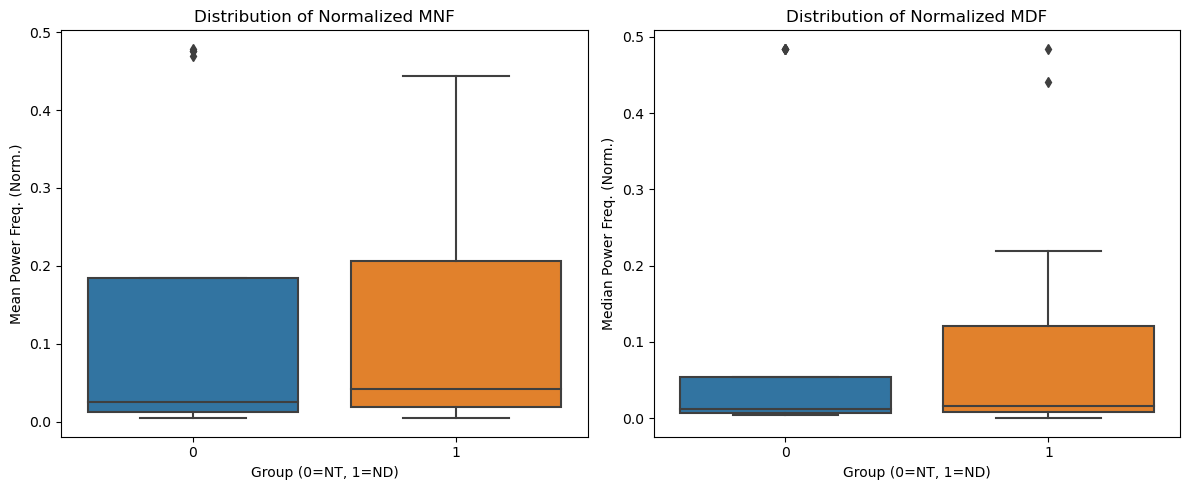

Displayed box plots for frequency features.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# Assuming 'combined_df' DataFrame exists (raw EMG data).
# Assuming 'subject_stats_df' DataFrame exists (with previous stats).

# --- Helper Functions for MNF and MDF ---
def mean_power_frequency(freq, psd):
    """Calculates Mean Power Frequency (MNF) from PSD."""
    if np.sum(psd) == 0 or len(psd) == 0: return np.nan
    return np.sum(psd * freq) / np.sum(psd)

def median_power_frequency(freq, psd):
    """Calculates Median Power Frequency (MDF) from PSD."""
    if np.sum(psd) == 0 or len(psd) == 0: return np.nan
    try:
        cumulative_power = np.cumsum(psd)
        total_power = cumulative_power[-1]
        if total_power == 0 or len(cumulative_power) == 0: return np.nan
        median_freq_index = np.searchsorted(cumulative_power, total_power / 2.0)
        if median_freq_index >= len(freq): median_freq_index = len(freq) - 1
        return freq[median_freq_index]
    except IndexError:
        return np.nan

# --- Function to Calculate PSD and Extract Features ---
def calculate_psd_features(emg_series):
    """Calculates PSD using Welch and extracts normalized MNF and MDF."""
    nperseg_val = min(len(emg_series), 256)
    if nperseg_val < 2: return {'mnf': np.nan, 'mdf': np.nan}
    try:
        freq, pxx = signal.welch(emg_series.values, fs=1.0, nperseg=nperseg_val, nfft=nperseg_val)
        if len(pxx) == 0 or len(freq) == 0 or np.sum(pxx) == 0:
             return {'mnf': np.nan, 'mdf': np.nan}
        mnf = mean_power_frequency(freq, pxx)
        mdf = median_power_frequency(freq, pxx)
        return {'mnf': mnf, 'mdf': mdf}
    except Exception as e:
        # print(f"PSD Error: {e}") # Optional debug print
        return {'mnf': np.nan, 'mdf': np.nan}

# --- Iterate through subjects to calculate features ---
print("Calculating frequency features (Normalized MNF, MDF) by iterating through subjects...")
all_freq_features = []
# Ensure we have the subject list and groups
subjects = subject_stats_df['subject_id'].unique()
subject_groups = subject_stats_df[['subject_id', 'group']].drop_duplicates().set_index('subject_id')['group']

for subject_id in subjects:
    # Get the raw EMG data for this subject
    emg_data = combined_df[combined_df['subject_id'] == subject_id]['EMG']
    if not emg_data.empty:
        # Calculate features
        freq_features = calculate_psd_features(emg_data)
        # Store results with subject ID and group
        freq_features['subject_id'] = subject_id
        freq_features['group'] = subject_groups.get(subject_id, np.nan) # Get group label
        all_freq_features.append(freq_features)
    else:
        print(f"Warning: No EMG data found for subject {subject_id}")
        all_freq_features.append({'subject_id': subject_id, 'group': subject_groups.get(subject_id, np.nan), 'mnf': np.nan, 'mdf': np.nan})


# Create DataFrame from the collected features
freq_features_df = pd.DataFrame(all_freq_features)
print("Frequency feature calculation complete.")
print("\nCalculated Frequency Features (first 5 rows):")
print(freq_features_df.head())

# --- Merge Frequency Features into subject_stats_df ---
try:
    if 'subject_stats_df' in locals() or 'subject_stats_df' in globals():
        print("\nMerging frequency features into subject_stats_df...")

        # Reset index just in case
        if not isinstance(subject_stats_df.index, pd.RangeIndex):
             subject_stats_df = subject_stats_df.reset_index()

        # Remove old frequency columns if they exist to avoid duplication
        cols_to_drop = [col for col in ['mnf', 'mdf'] if col in subject_stats_df.columns]
        if cols_to_drop:
            print(f"Removing existing columns before merging: {cols_to_drop}")
            subject_stats_df = subject_stats_df.drop(columns=cols_to_drop)

        # Merge the new frequency features
        subject_stats_df = pd.merge(subject_stats_df, freq_features_df[['subject_id', 'group', 'mnf', 'mdf']], on=['subject_id', 'group'], how='left')
        print("Merge successful.")

        # --- Verification ---
        print("\nVerifying final subject_stats_df...")
        mnf_nan_count = subject_stats_df['mnf'].isna().sum()
        mdf_nan_count = subject_stats_df['mdf'].isna().sum()
        if mnf_nan_count == 0 and mdf_nan_count == 0:
             print("Successfully added 'mnf' and 'mdf' features with no missing values.")
             print("\nFinal subject statistics including Frequency Features (first 5 rows):")
             cols_to_show = ['subject_id', 'group'] + [col for col in ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf'] if col in subject_stats_df.columns]
             print(subject_stats_df[cols_to_show].head())
             plot_ok = True
        else:
             print(f"Warning: Found NaN values after merge. MNF NaNs: {mnf_nan_count}, MDF NaNs: {mdf_nan_count}")
             print("Subjects with NaN frequency features:")
             print(subject_stats_df[subject_stats_df['mnf'].isna() | subject_stats_df['mdf'].isna()][['subject_id', 'group', 'mnf', 'mdf']])
             plot_ok = False # Prevent plotting if NaNs exist, needs handling

    else:
        print("Error: subject_stats_df not found. Cannot merge features.")
        plot_ok = False

except Exception as e:
    print(f"An error occurred during merge or verification: {e}")
    plot_ok = False

# --- Plotting Distributions of Frequency Features ---
if plot_ok:
    print("\nGenerating box plots for Frequency Feature group comparison...")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.boxplot(ax=axes[0], x='group', y='mnf', data=subject_stats_df)
    axes[0].set_title('Distribution of Normalized MNF')
    axes[0].set_xlabel('Group (0=NT, 1=ND)')
    axes[0].set_ylabel('Mean Power Freq. (Norm.)')

    sns.boxplot(ax=axes[1], x='group', y='mdf', data=subject_stats_df)
    axes[1].set_title('Distribution of Normalized MDF')
    axes[1].set_xlabel('Group (0=NT, 1=ND)')
    axes[1].set_ylabel('Median Power Freq. (Norm.)')

    plt.tight_layout()
    plt.show()
    print("Displayed box plots for frequency features.")
else:
    print("\nSkipping frequency feature plots due to errors or missing data.")

Calculating frequency features (Normalized MNF, MDF) by iterating through subjects...
Frequency feature calculation complete.

Merging frequency features into subject_stats_df...
Removing existing columns before merging: ['mnf', 'mdf']
Merge successful.

Verifying final subject_stats_df...
Successfully added 'mnf' and 'mdf' features with no missing values.

Final subject statistics including Frequency Features (first 5 rows):
      subject_id  group      mean        std  min  max         rms     wl  \
0   individual_1      0  297.7165  22.956974  234  393  298.599855   1495   
1  individual_10      0  303.4485   0.608714  301  305  303.449110    771   
2  individual_11      0  302.3820   8.236747  282  322  302.494106  21524   
3  individual_12      0  301.2925  37.688767  180  421  303.639430  45661   
4  individual_13      0  297.8170   6.138921  286  309  297.880233  21793   

        mnf       mdf  
0  0.005823  0.002969  
1  0.184880  0.050913  
2  0.478561  0.482652  
3  0.062378

e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Anaconda\Lib\site-package

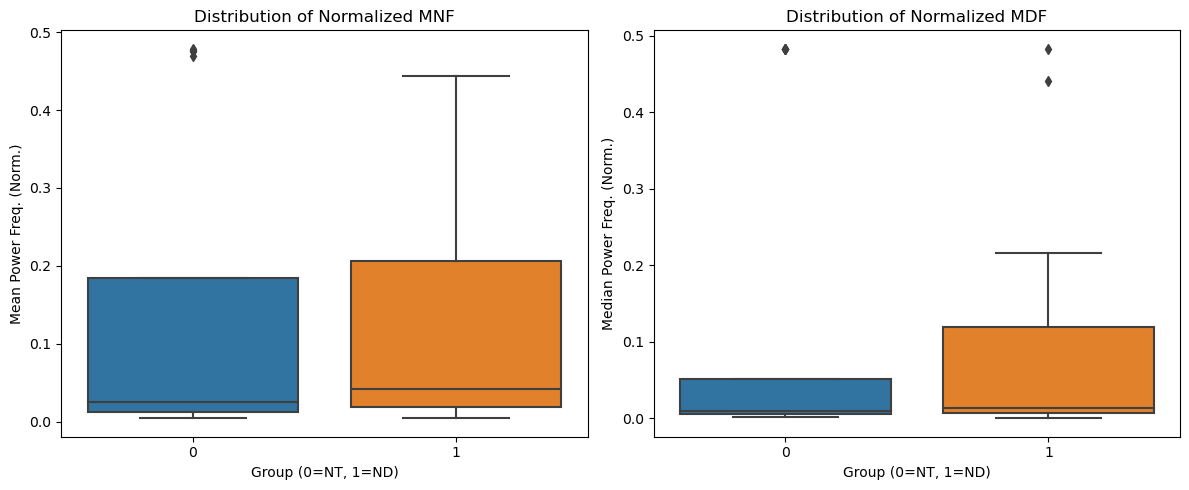

Displayed box plots for frequency features.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal # Import the signal processing library

# Assuming 'combined_df' DataFrame exists (raw EMG data).
# Assuming 'subject_stats_df' DataFrame exists and should already contain:
# ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl']
# If 'wl' or others are missing due to previous errors, this might need adjustment
# Let's check if subject_stats_df seems valid before proceeding
base_features_exist = False
if 'subject_stats_df' in locals() or 'subject_stats_df' in globals():
    required_cols = ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms', 'wl']
    if all(col in subject_stats_df.columns for col in required_cols):
        base_features_exist = True
    else:
        print("Warning: Existing subject_stats_df is missing some expected columns. Will proceed but might cause issues.")
else:
    print("Error: subject_stats_df not found. Cannot add frequency features. Please ensure previous steps completed.")
    # Stop execution if base stats are missing
    raise NameError("subject_stats_df not defined or incomplete")


# --- Helper Functions for MNF and MDF ---
def mean_power_frequency(freq, psd):
    """Calculates Mean Power Frequency (MNF) from PSD."""
    psd_sum = np.sum(psd)
    if psd_sum == 0 or len(psd) == 0: return np.nan
    return np.sum(psd * freq) / psd_sum

def median_power_frequency(freq, psd):
    """Calculates Median Power Frequency (MDF) from PSD."""
    if np.sum(psd) == 0 or len(psd) == 0: return np.nan
    try:
        cumulative_power = np.cumsum(psd)
        total_power = cumulative_power[-1]
        if total_power == 0 or len(cumulative_power) == 0: return np.nan
        median_freq_index = np.searchsorted(cumulative_power, total_power / 2.0)
        if median_freq_index >= len(freq): median_freq_index = len(freq) - 1
        # Simple interpolation between adjacent points if needed for more accuracy
        # Find points bounding the median power
        if cumulative_power[median_freq_index] == total_power / 2.0:
             return freq[median_freq_index]
        elif median_freq_index == 0:
             return freq[0] # Edge case: median freq is at the first bin
        else:
             # Linear interpolation
             f1, f2 = freq[median_freq_index - 1], freq[median_freq_index]
             p1, p2 = cumulative_power[median_freq_index - 1], cumulative_power[median_freq_index]
             mdf = np.interp(total_power / 2.0, [p1, p2], [f1, f2])
             return mdf
    except IndexError:
        return np.nan
    except Exception as e:
        # Catch any other unexpected errors during calculation
        print(f"Error in median_power_frequency: {e}")
        return np.nan


# --- Function to Calculate PSD and Extract Features ---
def calculate_psd_features(emg_series):
    """Calculates PSD using Welch and extracts normalized MNF and MDF."""
    nperseg_val = min(len(emg_series), 256)
    if nperseg_val < 2: return {'mnf': np.nan, 'mdf': np.nan}
    try:
        # Use Welch method for PSD estimation, fs=1.0 for normalized frequency
        freq, pxx = signal.welch(emg_series.values, fs=1.0, nperseg=nperseg_val, nfft=max(nperseg_val, 256)) # Use default or larger nfft

        if len(pxx) == 0 or len(freq) == 0 or np.sum(pxx) < 1e-10: # Check for effectively zero power
             # print(f"Warning: PSD calculation resulted in zero power or empty arrays for a segment.")
             return {'mnf': np.nan, 'mdf': np.nan}

        mnf = mean_power_frequency(freq, pxx)
        mdf = median_power_frequency(freq, pxx)
        return {'mnf': mnf, 'mdf': mdf}
    except Exception as e:
        # print(f"Error calculating PSD/Freq features for a subject's data segment: {e}")
        return {'mnf': np.nan, 'mdf': np.nan}

# --- Iterate through subjects to calculate features ---
print("Calculating frequency features (Normalized MNF, MDF) by iterating through subjects...")
all_freq_features = []
if base_features_exist:
    subject_group_map = subject_stats_df.set_index('subject_id')['group'].to_dict()
    all_subject_ids = subject_stats_df['subject_id'].unique()

    for subject_id in all_subject_ids:
        emg_data = combined_df[combined_df['subject_id'] == subject_id]['EMG']
        if not emg_data.empty:
            freq_features = calculate_psd_features(emg_data)
            freq_features['subject_id'] = subject_id
            # freq_features['group'] = subject_group_map.get(subject_id, np.nan) # Group already in subject_stats_df
            all_freq_features.append(freq_features)
        else:
            print(f"Warning: No EMG data found for subject {subject_id} in combined_df")
            all_freq_features.append({'subject_id': subject_id, 'mnf': np.nan, 'mdf': np.nan})

    # Create DataFrame from the collected features
    freq_features_df = pd.DataFrame(all_freq_features)
    print("Frequency feature calculation complete.")

    # --- Merge Frequency Features into subject_stats_df ---
    try:
        print("\nMerging frequency features into subject_stats_df...")
        # Remove old frequency columns if they exist
        cols_to_drop = [col for col in ['mnf', 'mdf'] if col in subject_stats_df.columns]
        if cols_to_drop:
            print(f"Removing existing columns before merging: {cols_to_drop}")
            subject_stats_df = subject_stats_df.drop(columns=cols_to_drop)

        # Merge based only on subject_id, assuming group is already correct in subject_stats_df
        subject_stats_df = pd.merge(subject_stats_df, freq_features_df[['subject_id', 'mnf', 'mdf']], on='subject_id', how='left')
        print("Merge successful.")

        # --- Verification ---
        print("\nVerifying final subject_stats_df...")
        mnf_nan_count = subject_stats_df['mnf'].isna().sum()
        mdf_nan_count = subject_stats_df['mdf'].isna().sum()
        if 'mnf' in subject_stats_df.columns and 'mdf' in subject_stats_df.columns and mnf_nan_count == 0 and mdf_nan_count == 0:
            print("Successfully added 'mnf' and 'mdf' features with no missing values.")
            print("\nFinal subject statistics including Frequency Features (first 5 rows):")
            cols_to_show = ['subject_id', 'group'] + [col for col in ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf'] if col in subject_stats_df.columns]
            print(subject_stats_df[cols_to_show].head())
            plot_ok = True
        else:
            print(f"Error/Warning: Problem verifying 'mnf'/'mdf' columns or found NaNs. MNF NaNs: {mnf_nan_count}, MDF NaNs: {mdf_nan_count}")
            if mnf_nan_count > 0 or mdf_nan_count > 0:
                 print("Subjects with NaN frequency features:")
                 print(subject_stats_df[subject_stats_df['mnf'].isna() | subject_stats_df['mdf'].isna()][['subject_id', 'group', 'mnf', 'mdf']])
            plot_ok = False # Prevent plotting if NaNs exist

    except Exception as e:
        print(f"An error occurred during merge or verification: {e}")
        plot_ok = False

    # --- Plotting Distributions of Frequency Features ---
    if plot_ok:
        print("\nGenerating box plots for Frequency Feature group comparison...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.boxplot(ax=axes[0], x='group', y='mnf', data=subject_stats_df)
        axes[0].set_title('Distribution of Normalized MNF')
        axes[0].set_xlabel('Group (0=NT, 1=ND)')
        axes[0].set_ylabel('Mean Power Freq. (Norm.)')

        sns.boxplot(ax=axes[1], x='group', y='mdf', data=subject_stats_df)
        axes[1].set_title('Distribution of Normalized MDF')
        axes[1].set_xlabel('Group (0=NT, 1=ND)')
        axes[1].set_ylabel('Median Power Freq. (Norm.)')

        plt.tight_layout()
        plt.show()
        print("Displayed box plots for frequency features.")
    else:
        print("\nSkipping frequency feature plots due to errors or missing data.")

else:
     print("Skipping frequency feature calculation because base subject_stats_df was not valid.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'subject_stats_df' DataFrame exists and includes 'mnf' and 'mdf' columns.

# Prepare Data with the full feature set
features = ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']
X = subject_stats_df[features]
y = subject_stats_df['group']

print(f"Using features: {features}")
print(f"Data shape: {X.shape}")

# Create a pipeline: Scale features then apply Random Forest Classifier
# Using the best parameters found by GridSearchCV previously, or reasonable defaults
# best_params = {'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} # From previous tuning
pipeline_rf_full = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42,
                                          n_estimators=50, # Using best from grid search
                                          max_depth=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2
                                          ))
])

# Define Cross-Validation strategy (Stratified K-Fold with 5 splits)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nRunning 5-Fold Stratified Cross-Validation with Random Forest (8 features)...")

# Perform cross-validation for multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

cv_results_rf_full = {}
all_scores_valid = True
try:
    # Calculate scores for each metric
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(pipeline_rf_full, X, y, cv=cv_strategy, scoring=scorer)
        # Check if any score calculation failed (might return NaN if a fold is problematic)
        if np.isnan(scores).any():
             print(f"Warning: NaN score encountered for {metric_name}. Scores: {scores}")
             all_scores_valid = False
        cv_results_rf_full[metric_name] = scores
        print(f"  {metric_name.capitalize()} scores per fold: {scores}")
        if all_scores_valid:
             print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
        else:
             print(f"  Mean {metric_name.capitalize()}: Calculation skipped due to NaN scores.")


    # Print overall summary only if all calculations were valid
    if all_scores_valid:
        print("\nCross-Validation Summary (Random Forest with 8 features):")
        for metric_name, scores in cv_results_rf_full.items():
          print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    else:
        print("\nCross-Validation Summary not fully calculated due to NaN scores in some folds.")

except ValueError as e:
     print(f"\nError during cross-validation: {e}")
     print("This might indicate issues with the data within folds, potentially caused by the small dataset size.")
except Exception as e:
    print(f"An unexpected error occurred during cross-validation: {e}")

Using features: ['mean', 'std', 'min', 'max', 'rms', 'wl', 'mnf', 'mdf']
Data shape: (43, 8)

Running 5-Fold Stratified Cross-Validation with Random Forest (8 features)...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Accuracy scores per fold: [0.77777778 0.66666667 0.88888889 0.75       0.75      ]
  Mean Accuracy: 0.7667 (+/- 0.0716)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Precision_macro scores per fold: [0.85714286 0.78571429 0.91666667 0.75       0.83333333]
  Mean Precision_macro: 0.8286 (+/- 0.0576)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Recall_macro scores per fold: [0.75  0.7   0.875 0.75  0.75 ]
  Mean Recall_macro: 0.7650 (+/- 0.0583)
  F1_macro scores per fold: [0.75       0.64935065 0.88311688 0.75       0.73333333]
  Mean F1_macro: 0.7532 (+/- 0.0749)

Cross-Validation Summary (Random Forest with 8 features):
  Mean Accuracy: 0.7667 (+/- 0.0716)
  Mean Precision_macro: 0.8286 (+/- 0.0576)
  Mean Recall_macro: 0.7650 (+/- 0.0583)
  Mean F1_macro: 0.7532 (+/- 0.0749)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Assuming 'subject_stats_df' DataFrame exists and contains at least
# ['subject_id', 'group', 'mean', 'std', 'min', 'max', 'rms']

# Prepare Data with the original 5 statistical features
features_base = ['mean', 'std', 'min', 'max', 'rms']
print(f"Using features: {features_base}")

try:
    X = subject_stats_df[features_base]
    y = subject_stats_df['group']

    # Create a pipeline: Scale features then apply Random Forest Classifier
    # Using default n_estimators=100 for this baseline check
    pipeline_rf_base = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Define Cross-Validation strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("\nRunning 5-Fold Stratified Cross-Validation with Random Forest (5 features)...")

    # Perform cross-validation for multiple metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
    }

    cv_results_rf_base = {}
    # Calculate scores for each metric
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(pipeline_rf_base, X, y, cv=cv_strategy, scoring=scorer)
        cv_results_rf_base[metric_name] = scores
        # print(f"  {metric_name.capitalize()} scores per fold: {scores}") # Optional: print fold scores
        print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

    print("\nCross-Validation Summary (Random Forest with 5 features):")
    for metric_name, scores in cv_results_rf_base.items():
      print(f"  Mean {metric_name.capitalize()}: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

except KeyError as e:
    print(f"\nError: A required feature column is missing from subject_stats_df: {e}")
    print("Please ensure the initial statistics were calculated successfully.")
except NameError as e:
    print(f"\nError: The DataFrame 'subject_stats_df' was not found. Did the previous steps run correctly? {e}")
except Exception as e:
    print(f"An unexpected error occurred during cross-validation: {e}")

Using features: ['mean', 'std', 'min', 'max', 'rms']

Running 5-Fold Stratified Cross-Validation with Random Forest (5 features)...


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Mean Accuracy: 0.7889 (+/- 0.0515)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Mean Precision_macro: 0.8381 (+/- 0.0536)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Mean Recall_macro: 0.7850 (+/- 0.0490)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages

  Mean F1_macro: 0.7783 (+/- 0.0541)

Cross-Validation Summary (Random Forest with 5 features):
  Mean Accuracy: 0.7889 (+/- 0.0515)
  Mean Precision_macro: 0.8381 (+/- 0.0536)
  Mean Recall_macro: 0.7850 (+/- 0.0490)
  Mean F1_macro: 0.7783 (+/- 0.0541)


e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Anaconda\Lib\site-packages